In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix
import time
from datetime import timedelta
import math
import os

import cifar10

cifar10.maybe_download_and_extract()

images_train, cls_train, labels_train = cifar10.load_training_data()
images_test, cls_test, labels_test = cifar10.load_test_data()

#extract mean
mean = np.mean(images_train,axis=(0,1,2,3))
images_train=images_train-mean
images_test=images_test-mean

X_val=images_train[:5000,:,:,:]
y_onehot_val=labels_train[:5000,:]
X_train=images_train[5000:,:,:,:]
y_onehot=labels_train[5000:,:]

Data has apparently already been downloaded and unpacked.
Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_1
Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_2
Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_3
Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_4
Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_5
Loading data: data/CIFAR-10/cifar-10-batches-py/test_batch


In [10]:
# evaluate performance on some data 
def perf_eval(logit_pred, y_true):
    """a function to evaluate performance of predicted y values vs true class labels"""
    # now look at some data
    print('    sample pred: {0}\n    sample true: {1}'.format(np.argmax(logit_pred[0:20],1),np.argmax(y_true[0:20],1)))
    # avg accuracy
    is_correct_vals = np.equal(np.argmax(logit_pred,1),np.argmax(y_true,1))
    #accuracy_vals = np.mean(is_correct_vals)
    #print('    mean classification accuracy: {0}%'.format(100*accuracy_vals))
    # Dig in a little deeper.  Where did we make correct predictions?  Does this seem reasonable?
    print('    correct predictions by class: {0}'.format(y_true[is_correct_vals,:].sum(axis=0)))
    
# cnn conv stuff
def conv(x, W):
    """simple wrapper for tf.nn.conv2d"""
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def maxpool(x):
    """simple wrapper for tf.nn.max_pool with stride size 2"""
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

def test_model(opt_method,model_type,batch_size,iterations):
    start_time = time.time()
    dir_name = 'logs/scratch04x/'
    n=50000
    n_val=5000
    
    with tf.Graph().as_default():
    # We build the model here as before
        x = tf.placeholder(tf.float32, [None, 32*32*3], name='x')
        y = tf.placeholder(tf.float32, [None, 10], name='y')
        pkeep = tf.placeholder(tf.float32, name='pkeep')

        with tf.name_scope('model'):
            logits = compute_logits(x, model_type, pkeep)
        with tf.name_scope('loss'):
            loss = compute_cross_entropy(logits=logits, y=y)
        with tf.name_scope('accuracy'):
            accuracy = compute_accuracy(logits, y)

        with tf.name_scope('opt'):
            if opt_method == 'sgd':
                opt = tf.train.GradientDescentOptimizer(0.5)
            elif opt_method == 'rms':
                opt = tf.train.RMSPropOptimizer(.001)
            elif opt_method == 'adam':
                opt = tf.train.AdamOptimizer(1e-4)
            train_step = opt.minimize(loss)

        with tf.Session() as sess:
            #summary_writer = tf.summary.FileWriter(dir_name, sess.graph)
            #summary_writer_train = tf.summary.FileWriter(dir_name+'/train', sess.graph)
            #summary_writer_val = tf.summary.FileWriter(dir_name+'/val')

            sess.run(tf.global_variables_initializer())
            
            accuracy_array=[]
            
            for i in range(iterations):
                batch = np.floor(np.random.rand(batch_size)*(n-n_val)).astype(int)
                X_batch = X_train[batch,:,:,:].reshape([batch_size,-1])
                y_batch = y_onehot[batch]

                # now run
                _  = sess.run((train_step),feed_dict={x: X_batch, y: y_batch, pkeep:0.85})

                # write the summary output to file
                #if i%100==0:
                    #summary_writer_train.add_summary(summary, i)

                # print diagnostics
                if i%10 == 0:
                    X_batch = X_train[0:1000,:,:,:].reshape([1000,-1])
                    y_batch = y_onehot[0:1000]
                    (train_error,train_logits) = sess.run((accuracy,logits), {x: X_batch, y: y_batch, pkeep:1.0})
                    print("\rStep {0:3d}: training accuracy {1:0.4f}".format(i, train_error), flush=True)
                    # further diagnostics
                    perf_eval(train_logits, y_batch)

                if i%10 == 0:
                    X_batch = X_val.reshape([n_val,-1])
                    y_batch = y_onehot_val
                    (val_error) = sess.run((accuracy), {x:X_batch, y:y_batch, pkeep:1.0})
                    print("\rStep {0:3d}: val accuracy {1:0.4f}".format(i, val_error), flush=True)
                    
                    accuracy_array.append(val_error)
                    #summary_writer_val.add_summary(summary, i)
    
    end_time = time.time()
    time_dif = end_time - start_time
    print (accuracy_array)
    print (time_dif/60)
    return accuracy_array,time_dif/60

In [29]:
# elaborate the compute_logits code to include a variety of models
def compute_logits(x, model_type, pkeep):
    if model_type=='lr':
        W = tf.get_variable('W', shape=[32*32*3, 10])
        b = tf.get_variable('b', shape=[10])
        logits = tf.add(tf.matmul(x, W), b, name='logits_lr')
    elif model_type=='vgg4_small_filters':
        x = tf.reshape(x, [-1,32,32,3])
        #cnn layer 1
        W_conv1 = tf.get_variable('W_conv1', shape=[3, 3, 3, 32])
        b_conv1 = tf.get_variable('b_conv1', shape=[32])
        h_conv1 = tf.nn.relu(tf.add(conv(x, W_conv1), b_conv1))
        #pool 1
        pool1=maxpool(h_conv1)
        #cnn layer 2
        W_conv2 = tf.get_variable('W_conv2', shape=[3, 3, 32, 64])
        b_conv2 = tf.get_variable('b_conv2', shape=[64])
        h_conv2 = tf.nn.relu(tf.add(conv(pool1, W_conv2), b_conv2))
        #pool 2
        pool2=maxpool(h_conv2)
        #cnn layer 3
        W_conv3 = tf.get_variable('W_conv3', shape=[3, 3, 64, 128])
        b_conv3 = tf.get_variable('b_conv3', shape=[128])
        h_conv3 = tf.nn.relu(tf.add(conv(pool2, W_conv3), b_conv3))
        #pool 3
        pool3=maxpool(h_conv3)
        # fc layer to logits
        shape=int(np.prod(pool3.get_shape()[1:]))
        flat = tf.reshape(pool3, [-1, shape])
        W_fc1 = tf.get_variable('W_fc1', [shape, 10])
        b_fc1 = tf.get_variable('b_fc1', [10])
        logits = tf.add(tf.matmul(flat, W_fc1), b_fc1, name='logits_vgg4_small_filters')
    elif model_type=='vgg6_small_filters':
        x = tf.reshape(x, [-1,32,32,3])
        #cnn layer 1
        W_conv1 = tf.get_variable('W_conv1', shape=[3, 3, 3, 32])
        b_conv1 = tf.get_variable('b_conv1', shape=[32])
        h_conv1 = tf.nn.relu(tf.add(conv(x, W_conv1), b_conv1))
        #cnn layer 2
        W_conv2 = tf.get_variable('W_conv2', shape=[3, 3, 32, 32])
        b_conv2 = tf.get_variable('b_conv2', shape=[32])
        h_conv2 = tf.nn.relu(tf.add(conv(h_conv1, W_conv2), b_conv2))        
        #pool 1
        pool1=maxpool(h_conv2)
        #cnn layer 3
        W_conv3 = tf.get_variable('W_conv3', shape=[3, 3, 32, 64])
        b_conv3 = tf.get_variable('b_conv3', shape=[64])
        h_conv3 = tf.nn.relu(tf.add(conv(pool1, W_conv3), b_conv3))
        #cnn layer 4
        W_conv4 = tf.get_variable('W_conv4', shape=[3, 3, 64, 64])
        b_conv4 = tf.get_variable('b_conv4', shape=[64])
        h_conv4 = tf.nn.relu(tf.add(conv(h_conv3, W_conv4), b_conv4))
        #pool 2
        pool2=maxpool(h_conv4)
        #cnn layer 5
        W_conv5 = tf.get_variable('W_conv5', shape=[3, 3, 64, 128])
        b_conv5 = tf.get_variable('b_conv5', shape=[128])
        h_conv5 = tf.nn.relu(tf.add(conv(pool2, W_conv5), b_conv5))
        #cnn layer 6
        W_conv6 = tf.get_variable('W_conv6', shape=[3, 3, 128, 128])
        b_conv6 = tf.get_variable('b_conv6', shape=[128])
        h_conv6 = tf.nn.relu(tf.add(conv(h_conv5, W_conv6), b_conv6))
        #pool 3
        pool3=maxpool(h_conv6)
        # fc layer to logits
        shape=int(np.prod(pool3.get_shape()[1:]))
        flat = tf.reshape(pool3, [-1, shape])
        W_fc1 = tf.get_variable('W_fc1', [shape, 10])
        b_fc1 = tf.get_variable('b_fc1', [10])
        logits = tf.add(tf.matmul(flat, W_fc1), b_fc1, name='logits_vgg6_small_filters')
    elif model_type=='vgg16':
        x = tf.reshape(x, [-1,32,32,3])
        #layer1
        #cnn layer 1.1
        W_conv11 = tf.get_variable('W_conv11', shape=[3, 3, 3, 64])
        b_conv11 = tf.get_variable('b_conv11', shape=[64])
        print(W_conv11,b_conv11)
        h_conv11 = tf.nn.relu(tf.add(conv(x, W_conv11), b_conv11))  #[batch,32,32,64]
        print(h_conv11)
        #cnn layer 1.2
        W_conv12 = tf.get_variable('W_conv12', shape=[3, 3, 64, 64])
        b_conv12 = tf.get_variable('b_conv12', shape=[64])
        h_conv12 = tf.nn.relu(tf.add(conv(h_conv11, W_conv12), b_conv12))
        #pool 1
        pool1=maxpool(h_conv12)

        #cnn layer 2.1
        W_conv21 = tf.get_variable('W_conv21', shape=[3, 3, 64, 128])
        b_conv21 = tf.get_variable('b_conv21', shape=[128])
        h_conv21 = tf.nn.relu(tf.add(conv(pool1, W_conv21), b_conv21))  
        #cnn layer 2.2
        W_conv22 = tf.get_variable('W_conv22', shape=[3, 3, 128, 128])
        b_conv22 = tf.get_variable('b_conv22', shape=[128])
        h_conv22 = tf.nn.relu(tf.add(conv(h_conv21, W_conv22), b_conv22))
        #pool 2
        pool2=maxpool(h_conv22)

        #cnn layer 3.1
        W_conv31 = tf.get_variable('W_conv31', shape=[3, 3, 128, 256])
        b_conv31 = tf.get_variable('b_conv31', shape=[256])
        h_conv31 = tf.nn.relu(tf.add(conv(pool2, W_conv31), b_conv31))  
        #cnn layer 3.2
        W_conv32 = tf.get_variable('W_conv32', shape=[3, 3, 256, 256])
        b_conv32 = tf.get_variable('b_conv32', shape=[256])
        h_conv32 = tf.nn.relu(tf.add(conv(h_conv31, W_conv32), b_conv32))
        #cnn layer 3.3
        W_conv33 = tf.get_variable('W_conv33', shape=[3, 3, 256, 256])
        b_conv33 = tf.get_variable('b_conv33', shape=[256])
        h_conv33 = tf.nn.relu(tf.add(conv(h_conv32, W_conv33), b_conv33))
        #pool 3
        pool3=maxpool(h_conv33)

        #cnn layer 4.1
        W_conv41 = tf.get_variable('W_conv41', shape=[3, 3, 256, 512])
        b_conv41 = tf.get_variable('b_conv41', shape=[512])
        h_conv41 = tf.nn.relu(tf.add(conv(pool3, W_conv41), b_conv41))  
        #cnn layer 4.2
        W_conv42 = tf.get_variable('W_conv42', shape=[3, 3, 512, 512])
        b_conv42 = tf.get_variable('b_conv42', shape=[512])
        h_conv42 = tf.nn.relu(tf.add(conv(h_conv41, W_conv42), b_conv42))
        #cnn layer 4.3
        W_conv43 = tf.get_variable('W_conv43', shape=[3, 3, 512, 512])
        b_conv43 = tf.get_variable('b_conv43', shape=[512])
        h_conv43 = tf.nn.relu(tf.add(conv(h_conv42, W_conv43), b_conv43))
        #pool4
        pool4=maxpool(h_conv43)

        #cnn layer 5.1
        W_conv51 = tf.get_variable('W_conv51', shape=[3, 3, 512, 512])
        b_conv51 = tf.get_variable('b_conv51', shape=[512])
        h_conv51 = tf.nn.relu(tf.add(conv(pool4, W_conv51), b_conv51))  
        #cnn layer 5.2
        W_conv52 = tf.get_variable('W_conv52', shape=[3, 3, 512, 512])
        b_conv52 = tf.get_variable('b_conv52', shape=[512])
        h_conv52 = tf.nn.relu(tf.add(conv(h_conv51, W_conv52), b_conv52))
        #cnn layer 5.3
        W_conv53 = tf.get_variable('W_conv53', shape=[3, 3, 512, 512])
        b_conv53 = tf.get_variable('b_conv53', shape=[512])
        h_conv53 = tf.nn.relu(tf.add(conv(h_conv52, W_conv53), b_conv53))
        #pool 5
        pool5=maxpool(h_conv53)

        #from softmax to logits
        shape=int(np.prod(pool5.get_shape()[1:]))
        pool5_flat=tf.reshape(pool5,[-1,shape])
        W_sf = tf.get_variable('W_sf', shape=[shape,10])
        b_sf = tf.get_variable('b_sf', shape=[10])
        logits = tf.add(tf.matmul(pool5_flat, W_sf), b_sf, name='logits_vgg16')
    return logits

def compute_cross_entropy(logits, y):
    # Compute the average cross-entropy across all the examples.
    numerical_instability_example = 0
    if numerical_instability_example:
        y_pred = tf.nn.softmax(logits, name='y_pred') # the predicted probability for each example.
        cross_ent = tf.reduce_mean(-tf.reduce_sum(y * tf.log(y_pred), reduction_indices=[1]))
    else:
        print(logits,y)
        sm_ce = tf.nn.softmax_cross_entropy_with_logits(labels=y,logits=logits, name='cross_ent_terms')
        cross_ent = tf.reduce_mean(sm_ce, name='cross_ent')
    return cross_ent

def compute_accuracy(logits, y):
    prediction = tf.argmax(logits, 1, name='pred_class')
    true_label = tf.argmax(y, 1, name='true_class')
    accuracy = tf.reduce_mean(tf.cast(tf.equal(prediction, true_label), tf.float32))
    return accuracy

### vgg6_small_filters

In [30]:
accuracy2,time2=test_model('adam','vgg6_small_filters',64,20001)

Tensor("model/logits_vgg6_small_filters:0", shape=(?, 10), dtype=float32) Tensor("y:0", shape=(?, 10), dtype=float32)
Step   0: training accuracy 0.0910
    sample pred: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
    sample true: [6 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9 6]
    correct predictions by class: [  0.  91.   0.   0.   0.   0.   0.   0.   0.   0.]
Step   0: val accuracy 0.0920
Step  10: training accuracy 0.1310
    sample pred: [6 1 1 0 6 6 6 6 6 1 6 1 6 0 1 1 6 6 6 6]
    sample true: [6 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9 6]
    correct predictions by class: [ 17.  29.   0.   0.   0.   0.  85.   0.   0.   0.]
Step  10: val accuracy 0.1344
Step  20: training accuracy 0.1950
    sample pred: [6 9 0 9 6 6 6 6 6 9 6 9 6 0 9 0 6 6 6 6]
    sample true: [6 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9 6]
    correct predictions by class: [ 39.   0.   0.   0.   0.   0.  93.   0.   0.  63.]
Step  20: val accuracy 0.1920
Step  30: training accuracy 0.1540
    sample pred: [9 9 9 9 5 9 9 9 9 9 9 

    sample pred: [1 9 8 1 5 6 4 6 1 9 0 9 2 9 9 0 1 6 7 4]
    sample true: [6 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9 6]
    correct predictions by class: [ 57.  38.   8.   3.  28.  32.  43.  50.  35.  47.]
Step 300: val accuracy 0.3576
Step 310: training accuracy 0.3570
    sample pred: [6 9 1 1 3 6 4 6 6 9 0 9 2 9 1 0 5 6 6 4]
    sample true: [6 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9 6]
    correct predictions by class: [ 36.  45.  10.   7.  34.  36.  61.  28.  38.  62.]
Step 310: val accuracy 0.3644
Step 320: training accuracy 0.3650
    sample pred: [6 9 1 1 3 6 4 6 6 9 0 9 2 9 1 0 3 6 6 4]
    sample true: [6 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9 6]
    correct predictions by class: [ 40.  38.   6.  15.  30.  23.  64.  55.  37.  57.]
Step 320: val accuracy 0.3714
Step 330: training accuracy 0.3690
    sample pred: [6 9 1 1 3 6 4 6 6 9 0 9 2 9 1 0 1 6 9 4]
    sample true: [6 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9 6]
    correct predictions by class: [ 30.  50.  11.  13.  35.  25.  45.  54. 

Step 600: val accuracy 0.4346
Step 610: training accuracy 0.4100
    sample pred: [6 9 1 1 3 6 4 6 6 9 0 9 2 9 1 0 8 6 9 4]
    sample true: [6 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9 6]
    correct predictions by class: [ 31.  50.  25.  24.  42.  31.  40.  45.  71.  51.]
Step 610: val accuracy 0.4412
Step 620: training accuracy 0.4420
    sample pred: [6 9 1 1 3 6 4 6 6 9 0 9 2 9 1 0 1 6 9 3]
    sample true: [6 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9 6]
    correct predictions by class: [ 47.  56.  17.  27.  29.  41.  46.  60.  52.  67.]
Step 620: val accuracy 0.4406
Step 630: training accuracy 0.4280
    sample pred: [6 9 1 1 3 6 4 6 6 9 0 9 2 9 1 0 1 6 9 4]
    sample true: [6 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9 6]
    correct predictions by class: [ 46.  54.  17.  30.  37.  24.  55.  59.  40.  66.]
Step 630: val accuracy 0.4370
Step 640: training accuracy 0.4390
    sample pred: [7 9 1 1 3 6 4 6 6 9 0 9 2 9 1 0 1 6 9 3]
    sample true: [6 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9 6]
    correc

Step 910: val accuracy 0.4696
Step 920: training accuracy 0.4800
    sample pred: [5 9 9 1 3 6 4 6 6 9 0 9 4 9 9 0 8 6 9 4]
    sample true: [6 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9 6]
    correct predictions by class: [ 46.  44.  21.  22.  42.  64.  46.  61.  62.  72.]
Step 920: val accuracy 0.4636
Step 930: training accuracy 0.4850
    sample pred: [5 9 1 1 3 6 4 6 6 9 0 9 4 1 1 0 1 6 9 4]
    sample true: [6 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9 6]
    correct predictions by class: [ 55.  59.  35.  28.  29.  39.  47.  67.  59.  67.]
Step 930: val accuracy 0.4788
Step 940: training accuracy 0.4890
    sample pred: [4 9 1 1 3 6 4 6 3 9 0 9 4 1 1 0 8 6 9 4]
    sample true: [6 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9 6]
    correct predictions by class: [ 48.  51.  28.  28.  54.  41.  43.  60.  68.  68.]
Step 940: val accuracy 0.4812
Step 950: training accuracy 0.4760
    sample pred: [5 9 1 1 3 6 4 6 3 9 0 9 4 1 1 0 8 6 9 4]
    sample true: [6 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9 6]
    correc

Step 1220: val accuracy 0.5032
Step 1230: training accuracy 0.5060
    sample pred: [5 9 1 1 3 2 4 6 3 9 0 9 4 1 1 0 8 6 1 4]
    sample true: [6 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9 6]
    correct predictions by class: [ 46.  63.  36.  18.  49.  56.  47.  61.  67.  63.]
Step 1230: val accuracy 0.4998
Step 1240: training accuracy 0.4950
    sample pred: [6 9 1 1 3 6 4 6 6 9 0 9 6 9 1 0 8 6 9 6]
    sample true: [6 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9 6]
    correct predictions by class: [ 52.  54.  34.  19.  24.  39.  65.  75.  57.  76.]
Step 1240: val accuracy 0.4932
Step 1250: training accuracy 0.4860
    sample pred: [2 9 1 1 3 2 4 3 3 9 0 9 2 1 1 0 8 6 1 4]
    sample true: [6 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9 6]
    correct predictions by class: [ 44.  56.  57.  33.  25.  41.  34.  70.  64.  62.]
Step 1250: val accuracy 0.5026
Step 1260: training accuracy 0.4890
    sample pred: [4 9 1 1 3 4 4 6 3 9 0 9 4 1 1 0 8 6 1 4]
    sample true: [6 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9 6]
  

    sample pred: [7 9 1 1 3 2 4 6 3 9 0 9 2 1 1 0 8 6 1 6]
    sample true: [6 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9 6]
    correct predictions by class: [ 66.  59.  42.  37.  29.  46.  47.  62.  66.  67.]
Step 1530: val accuracy 0.5224
Step 1540: training accuracy 0.5290
    sample pred: [7 9 9 1 3 2 4 6 6 9 0 9 2 9 1 0 8 6 9 6]
    sample true: [6 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9 6]
    correct predictions by class: [ 50.  59.  51.  19.  24.  46.  65.  77.  57.  81.]
Step 1540: val accuracy 0.5100
Step 1550: training accuracy 0.5200
    sample pred: [7 9 1 1 3 2 4 3 3 9 0 9 2 1 1 0 3 3 9 6]
    sample true: [6 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9 6]
    correct predictions by class: [ 44.  61.  41.  50.  31.  44.  42.  65.  65.  77.]
Step 1550: val accuracy 0.5168
Step 1560: training accuracy 0.5230
    sample pred: [5 9 1 1 3 2 4 6 3 9 0 9 2 1 1 0 8 6 1 6]
    sample true: [6 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9 6]
    correct predictions by class: [ 62.  61.  41.  28.  43.  54.  54.

Step 1830: val accuracy 0.5442
Step 1840: training accuracy 0.5420
    sample pred: [7 9 1 1 3 2 4 6 6 9 0 9 4 1 1 0 8 6 1 6]
    sample true: [6 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9 6]
    correct predictions by class: [ 55.  61.  48.  24.  38.  47.  62.  75.  71.  61.]
Step 1840: val accuracy 0.5432
Step 1850: training accuracy 0.5140
    sample pred: [7 7 1 1 3 2 4 3 3 9 0 9 4 1 1 0 8 3 1 6]
    sample true: [6 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9 6]
    correct predictions by class: [ 57.  57.  32.  55.  47.  39.  38.  74.  58.  57.]
Step 1850: val accuracy 0.5164
Step 1860: training accuracy 0.5250
    sample pred: [2 9 1 1 3 2 4 6 3 9 0 9 2 9 1 0 8 6 9 6]
    sample true: [6 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9 6]
    correct predictions by class: [ 49.  60.  67.  33.  25.  32.  54.  54.  65.  86.]
Step 1860: val accuracy 0.5244
Step 1870: training accuracy 0.5300
    sample pred: [4 7 1 1 3 2 4 6 6 9 0 9 4 1 1 0 8 6 1 6]
    sample true: [6 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9 6]
  

    sample pred: [4 9 1 1 3 2 4 6 6 9 0 9 4 9 1 0 8 6 1 6]
    sample true: [6 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9 6]
    correct predictions by class: [ 50.  63.  39.  36.  45.  30.  74.  65.  77.  65.]
Step 2140: val accuracy 0.5372
Step 2150: training accuracy 0.5650
    sample pred: [7 9 1 1 3 2 4 3 3 9 0 9 2 9 1 0 8 6 9 6]
    sample true: [6 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9 6]
    correct predictions by class: [ 59.  62.  49.  41.  36.  45.  56.  70.  68.  79.]
Step 2150: val accuracy 0.5522
Step 2160: training accuracy 0.5530
    sample pred: [2 9 1 1 3 2 4 6 3 9 0 9 2 1 1 0 8 6 1 6]
    sample true: [6 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9 6]
    correct predictions by class: [ 52.  74.  54.  36.  35.  37.  56.  72.  72.  65.]
Step 2160: val accuracy 0.5528
Step 2170: training accuracy 0.5590
    sample pred: [4 9 1 1 3 2 4 6 6 9 0 9 6 9 1 0 8 6 9 6]
    sample true: [6 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9 6]
    correct predictions by class: [ 47.  61.  40.  30.  40.  42.  64.

Step 2440: val accuracy 0.5572
Step 2450: training accuracy 0.5630
    sample pred: [5 9 1 1 3 2 4 6 6 9 0 9 4 1 1 0 8 6 1 6]
    sample true: [6 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9 6]
    correct predictions by class: [ 57.  72.  37.  32.  40.  54.  71.  65.  77.  58.]
Step 2450: val accuracy 0.5604
Step 2460: training accuracy 0.5700
    sample pred: [7 7 1 1 3 2 4 3 3 9 0 9 2 1 1 0 8 3 9 6]
    sample true: [6 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9 6]
    correct predictions by class: [ 65.  60.  61.  50.  33.  31.  43.  81.  76.  70.]
Step 2460: val accuracy 0.5564
Step 2470: training accuracy 0.5670
    sample pred: [5 9 1 1 3 2 4 3 3 9 0 9 4 9 1 0 8 6 9 6]
    sample true: [6 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9 6]
    correct predictions by class: [ 71.  54.  42.  31.  43.  58.  64.  62.  62.  80.]
Step 2470: val accuracy 0.5516
Step 2480: training accuracy 0.5520
    sample pred: [2 9 1 1 1 2 4 3 3 9 0 9 1 1 1 0 8 6 1 6]
    sample true: [6 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9 6]
  

    sample pred: [6 7 1 1 3 2 7 3 3 9 0 9 4 1 1 0 8 3 9 6]
    sample true: [6 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9 6]
    correct predictions by class: [ 61.  67.  39.  40.  37.  47.  65.  80.  72.  77.]
Step 2750: val accuracy 0.5716
Step 2760: training accuracy 0.5850
    sample pred: [2 7 1 1 3 2 4 3 3 9 0 9 2 1 1 0 8 3 1 6]
    sample true: [6 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9 6]
    correct predictions by class: [ 44.  74.  58.  40.  43.  32.  58.  78.  83.  75.]
Step 2760: val accuracy 0.5790
Step 2770: training accuracy 0.5940
    sample pred: [2 7 1 1 3 2 4 3 6 9 0 9 2 1 1 0 8 6 1 6]
    sample true: [6 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9 6]
    correct predictions by class: [ 67.  71.  59.  34.  39.  42.  63.  76.  74.  69.]
Step 2770: val accuracy 0.5832
Step 2780: training accuracy 0.5860
    sample pred: [6 7 1 1 3 2 7 3 6 9 0 9 2 1 1 0 8 6 1 6]
    sample true: [6 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9 6]
    correct predictions by class: [ 62.  74.  42.  37.  35.  43.  71.

Step 3050: val accuracy 0.5810
Step 3060: training accuracy 0.5890
    sample pred: [2 3 1 0 3 2 4 3 3 9 0 9 4 1 1 0 8 5 1 6]
    sample true: [6 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9 6]
    correct predictions by class: [ 70.  70.  43.  38.  33.  59.  59.  66.  80.  71.]
Step 3060: val accuracy 0.5930
Step 3070: training accuracy 0.6100
    sample pred: [2 7 9 1 3 2 4 3 3 9 0 9 4 9 1 0 8 5 9 6]
    sample true: [6 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9 6]
    correct predictions by class: [ 65.  69.  44.  29.  42.  60.  58.  78.  74.  91.]
Step 3070: val accuracy 0.5892
Step 3080: training accuracy 0.5960
    sample pred: [2 7 1 1 3 2 4 3 3 9 0 9 4 1 1 0 8 3 1 6]
    sample true: [6 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9 6]
    correct predictions by class: [ 66.  75.  54.  49.  40.  37.  56.  70.  75.  74.]
Step 3080: val accuracy 0.5936
Step 3090: training accuracy 0.6060
    sample pred: [2 7 1 1 3 2 4 3 3 9 0 9 4 9 1 0 8 3 1 6]
    sample true: [6 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9 6]
  

    sample pred: [7 7 1 1 3 2 4 3 3 9 0 9 4 9 1 0 8 3 1 6]
    sample true: [6 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9 6]
    correct predictions by class: [ 64.  65.  49.  43.  46.  56.  62.  79.  86.  68.]
Step 3360: val accuracy 0.6030
Step 3370: training accuracy 0.6090
    sample pred: [7 7 1 1 3 2 4 3 3 9 0 9 4 9 1 0 2 3 9 6]
    sample true: [6 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9 6]
    correct predictions by class: [ 67.  68.  46.  44.  47.  54.  63.  78.  55.  87.]
Step 3370: val accuracy 0.5982
Step 3380: training accuracy 0.6090
    sample pred: [2 7 1 1 3 2 3 3 3 9 0 9 4 9 1 0 8 3 9 6]
    sample true: [6 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9 6]
    correct predictions by class: [ 74.  66.  54.  51.  41.  37.  62.  78.  73.  73.]
Step 3380: val accuracy 0.6018
Step 3390: training accuracy 0.5970
    sample pred: [2 7 9 1 3 2 3 3 3 9 0 9 2 9 1 0 8 3 9 6]
    sample true: [6 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9 6]
    correct predictions by class: [ 46.  67.  64.  50.  23.  61.  59.

Step 3660: val accuracy 0.5852
Step 3670: training accuracy 0.6190
    sample pred: [2 0 1 1 3 2 4 3 3 9 0 9 0 0 1 0 8 5 1 6]
    sample true: [6 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9 6]
    correct predictions by class: [ 75.  73.  48.  43.  48.  50.  64.  68.  84.  66.]
Step 3670: val accuracy 0.6068
Step 3680: training accuracy 0.6280
    sample pred: [2 0 1 0 3 2 3 3 3 9 0 9 2 9 1 0 8 5 1 6]
    sample true: [6 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9 6]
    correct predictions by class: [ 69.  60.  65.  47.  43.  42.  63.  77.  81.  81.]
Step 3680: val accuracy 0.6050
Step 3690: training accuracy 0.6250
    sample pred: [7 7 1 1 3 2 3 3 3 9 0 9 4 9 1 0 8 3 1 6]
    sample true: [6 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9 6]
    correct predictions by class: [ 62.  71.  43.  58.  48.  40.  64.  84.  75.  80.]
Step 3690: val accuracy 0.5958
Step 3700: training accuracy 0.6160
    sample pred: [2 3 1 1 3 2 3 3 3 9 0 9 2 0 1 0 8 3 1 6]
    sample true: [6 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9 6]
  

    sample pred: [7 7 9 1 3 2 4 3 3 9 0 9 4 9 1 0 8 5 1 6]
    sample true: [6 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9 6]
    correct predictions by class: [ 73.  67.  51.  37.  47.  50.  68.  85.  76.  93.]
Step 3970: val accuracy 0.6162
Step 3980: training accuracy 0.6310
    sample pred: [6 0 9 1 3 2 3 3 3 9 0 9 2 1 1 0 8 5 1 6]
    sample true: [6 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9 6]
    correct predictions by class: [ 61.  73.  59.  46.  26.  50.  71.  79.  85.  81.]
Step 3980: val accuracy 0.6084
Step 3990: training accuracy 0.6380
    sample pred: [7 7 9 1 3 2 4 3 3 9 0 9 4 9 1 0 3 5 1 6]
    sample true: [6 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9 6]
    correct predictions by class: [ 67.  72.  53.  50.  51.  53.  52.  81.  66.  93.]
Step 3990: val accuracy 0.6094
Step 4000: training accuracy 0.6520
    sample pred: [6 0 1 1 3 2 4 3 3 9 0 9 4 9 1 0 8 6 1 6]
    sample true: [6 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9 6]
    correct predictions by class: [ 73.  75.  52.  40.  51.  52.  68.

Step 4270: val accuracy 0.6114
Step 4280: training accuracy 0.6480
    sample pred: [7 3 9 1 3 2 3 3 3 9 0 9 4 9 1 0 2 3 9 6]
    sample true: [6 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9 6]
    correct predictions by class: [ 61.  65.  63.  48.  47.  55.  64.  77.  77.  91.]
Step 4280: val accuracy 0.6138
Step 4290: training accuracy 0.6460
    sample pred: [4 0 1 1 3 2 4 3 3 9 0 9 4 9 1 0 2 3 1 6]
    sample true: [6 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9 6]
    correct predictions by class: [ 69.  76.  62.  46.  56.  55.  62.  68.  66.  86.]
Step 4290: val accuracy 0.6128
Step 4300: training accuracy 0.6220
    sample pred: [6 7 1 1 3 2 4 3 3 9 0 9 0 1 1 0 8 6 1 6]
    sample true: [6 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9 6]
    correct predictions by class: [ 65.  77.  55.  31.  47.  39.  77.  85.  86.  60.]
Step 4300: val accuracy 0.6068
Step 4310: training accuracy 0.6300
    sample pred: [4 7 1 1 3 2 3 3 3 9 0 9 4 9 1 0 8 5 1 6]
    sample true: [6 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9 6]
  

    sample pred: [6 7 1 1 3 2 4 3 3 9 0 9 4 0 1 0 2 5 1 6]
    sample true: [6 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9 6]
    correct predictions by class: [ 76.  75.  54.  43.  54.  62.  76.  77.  65.  78.]
Step 4580: val accuracy 0.6286
Step 4590: training accuracy 0.6640
    sample pred: [6 7 1 1 3 2 4 3 3 9 0 9 4 1 1 0 8 3 1 6]
    sample true: [6 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9 6]
    correct predictions by class: [ 61.  76.  54.  48.  65.  54.  60.  84.  85.  77.]
Step 4590: val accuracy 0.6220
Step 4600: training accuracy 0.6540
    sample pred: [2 0 1 1 3 2 3 3 3 9 0 9 0 9 1 0 8 3 1 6]
    sample true: [6 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9 6]
    correct predictions by class: [ 74.  73.  63.  50.  31.  52.  67.  77.  82.  85.]
Step 4600: val accuracy 0.6242
Step 4610: training accuracy 0.6530
    sample pred: [6 0 9 0 3 2 4 3 3 9 0 9 4 9 1 0 8 3 1 6]
    sample true: [6 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9 6]
    correct predictions by class: [ 73.  65.  50.  47.  61.  50.  69.

Step 4880: val accuracy 0.6276
Step 4890: training accuracy 0.6600
    sample pred: [7 7 1 1 5 2 7 3 3 9 0 9 4 9 1 0 8 5 1 6]
    sample true: [6 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9 6]
    correct predictions by class: [ 55.  76.  58.  35.  53.  63.  68.  92.  86.  74.]
Step 4890: val accuracy 0.6286
Step 4900: training accuracy 0.6690
    sample pred: [6 7 1 1 3 2 3 3 3 9 0 9 4 9 1 0 3 3 1 6]
    sample true: [6 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9 6]
    correct predictions by class: [ 68.  72.  54.  51.  57.  50.  77.  84.  72.  84.]
Step 4900: val accuracy 0.6274
Step 4910: training accuracy 0.6460
    sample pred: [2 0 1 0 3 2 3 3 3 9 0 9 2 9 1 0 2 3 1 6]
    sample true: [6 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9 6]
    correct predictions by class: [ 77.  71.  73.  50.  29.  48.  60.  78.  82.  78.]
Step 4910: val accuracy 0.6256
Step 4920: training accuracy 0.6760
    sample pred: [2 0 1 1 3 2 4 3 3 9 0 9 4 9 1 0 2 5 1 6]
    sample true: [6 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9 6]
  

    sample pred: [2 7 9 0 3 2 4 3 3 9 0 9 2 9 1 0 2 3 1 6]
    sample true: [6 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9 6]
    correct predictions by class: [ 74.  67.  64.  45.  49.  56.  67.  86.  81.  90.]
Step 5190: val accuracy 0.6440
Step 5200: training accuracy 0.6750
    sample pred: [7 7 9 0 5 2 4 3 3 9 0 9 4 9 1 0 2 3 1 6]
    sample true: [6 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9 6]
    correct predictions by class: [ 78.  74.  52.  40.  56.  65.  67.  87.  77.  79.]
Step 5200: val accuracy 0.6360
Step 5210: training accuracy 0.6870
    sample pred: [2 7 9 0 3 2 4 3 3 9 0 9 4 9 1 0 0 5 1 6]
    sample true: [6 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9 6]
    correct predictions by class: [ 78.  72.  56.  41.  59.  53.  73.  85.  75.  95.]
Step 5210: val accuracy 0.6328
Step 5220: training accuracy 0.6610
    sample pred: [2 0 9 0 3 2 3 3 3 9 0 9 2 9 1 0 0 3 1 6]
    sample true: [6 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9 6]
    correct predictions by class: [ 72.  77.  61.  57.  48.  36.  67.

Step 5490: val accuracy 0.6492
Step 5500: training accuracy 0.6760
    sample pred: [2 7 9 0 3 2 3 3 3 9 0 9 4 9 1 0 0 3 1 6]
    sample true: [6 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9 6]
    correct predictions by class: [ 72.  70.  58.  47.  48.  48.  65.  90.  81.  97.]
Step 5500: val accuracy 0.6390
Step 5510: training accuracy 0.6830
    sample pred: [2 0 9 0 3 2 3 3 3 9 0 9 4 9 1 0 0 6 1 6]
    sample true: [6 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9 6]
    correct predictions by class: [ 71.  70.  59.  42.  60.  59.  77.  79.  84.  82.]
Step 5510: val accuracy 0.6388
Step 5520: training accuracy 0.6710
    sample pred: [6 7 9 0 3 2 3 3 3 9 0 9 4 9 1 0 0 5 1 6]
    sample true: [6 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9 6]
    correct predictions by class: [ 74.  71.  44.  52.  48.  54.  66.  88.  78.  96.]
Step 5520: val accuracy 0.6374
Step 5530: training accuracy 0.6880
    sample pred: [2 3 9 0 3 2 3 3 3 9 0 9 4 9 1 0 2 3 1 6]
    sample true: [6 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9 6]
  

    sample pred: [4 7 9 1 3 2 3 3 3 9 0 9 4 9 1 0 3 3 1 6]
    sample true: [6 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9 6]
    correct predictions by class: [ 58.  74.  66.  60.  60.  48.  62.  87.  79.  90.]
Step 5800: val accuracy 0.6430
Step 5810: training accuracy 0.6820
    sample pred: [6 0 9 0 5 2 3 3 3 9 0 9 4 9 1 0 0 5 1 6]
    sample true: [6 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9 6]
    correct predictions by class: [ 69.  72.  58.  40.  54.  63.  75.  83.  84.  84.]
Step 5810: val accuracy 0.6532
Step 5820: training accuracy 0.6900
    sample pred: [6 0 9 0 3 2 3 3 3 9 0 9 4 9 1 0 0 3 1 6]
    sample true: [6 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9 6]
    correct predictions by class: [ 80.  74.  55.  64.  50.  57.  64.  86.  82.  78.]
Step 5820: val accuracy 0.6460
Step 5830: training accuracy 0.6900
    sample pred: [6 7 9 0 3 2 3 3 3 9 0 9 4 9 1 0 0 3 1 6]
    sample true: [6 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9 6]
    correct predictions by class: [ 64.  70.  64.  55.  57.  44.  75.

Step 6100: val accuracy 0.6584
Step 6110: training accuracy 0.6810
    sample pred: [6 0 9 0 5 2 3 3 3 9 0 9 4 9 1 0 0 5 1 6]
    sample true: [6 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9 6]
    correct predictions by class: [ 70.  76.  61.  45.  50.  69.  66.  77.  77.  90.]
Step 6110: val accuracy 0.6530
Step 6120: training accuracy 0.6970
    sample pred: [6 0 1 0 3 2 3 3 3 9 0 9 2 9 1 0 0 6 1 6]
    sample true: [6 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9 6]
    correct predictions by class: [ 82.  77.  69.  54.  50.  43.  74.  89.  78.  81.]
Step 6120: val accuracy 0.6502
Step 6130: training accuracy 0.6980
    sample pred: [6 0 9 0 5 2 3 3 3 9 0 9 4 9 1 0 0 3 1 6]
    sample true: [6 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9 6]
    correct predictions by class: [ 75.  71.  53.  49.  58.  62.  76.  83.  75.  96.]
Step 6130: val accuracy 0.6528
Step 6140: training accuracy 0.6980
    sample pred: [2 0 9 0 5 2 4 3 3 9 0 9 4 9 1 0 0 5 1 6]
    sample true: [6 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9 6]
  

    sample pred: [2 7 1 1 5 2 3 3 3 9 0 9 4 9 1 0 0 5 1 6]
    sample true: [6 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9 6]
    correct predictions by class: [ 62.  77.  60.  46.  55.  67.  64.  92.  84.  91.]
Step 6410: val accuracy 0.6594
Step 6420: training accuracy 0.6890
    sample pred: [2 0 9 0 3 2 3 3 3 9 0 9 2 9 1 0 0 3 1 6]
    sample true: [6 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9 6]
    correct predictions by class: [ 73.  75.  65.  53.  47.  56.  64.  82.  86.  88.]
Step 6420: val accuracy 0.6620
Step 6430: training accuracy 0.6990
    sample pred: [6 7 9 0 3 2 2 3 6 9 0 9 4 9 1 0 0 6 1 6]
    sample true: [6 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9 6]
    correct predictions by class: [ 74.  77.  61.  39.  54.  44.  84.  95.  84.  87.]
Step 6430: val accuracy 0.6518
Step 6440: training accuracy 0.7120
    sample pred: [4 0 9 0 3 2 3 3 3 9 0 9 4 9 1 0 0 3 1 6]
    sample true: [6 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9 6]
    correct predictions by class: [ 77.  77.  64.  52.  61.  53.  70.

Step 6710: val accuracy 0.6558
Step 6720: training accuracy 0.7100
    sample pred: [6 7 9 0 5 2 3 3 3 9 0 9 4 9 1 0 0 3 1 6]
    sample true: [6 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9 6]
    correct predictions by class: [ 69.  84.  57.  57.  54.  65.  71.  91.  76.  86.]
Step 6720: val accuracy 0.6554
Step 6730: training accuracy 0.7080
    sample pred: [6 7 9 0 3 2 3 3 3 9 0 9 2 9 1 0 0 3 1 6]
    sample true: [6 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9 6]
    correct predictions by class: [ 78.  73.  62.  57.  50.  47.  77.  95.  84.  85.]
Step 6730: val accuracy 0.6584
Step 6740: training accuracy 0.7230
    sample pred: [6 7 9 0 3 2 3 3 3 9 0 9 4 9 1 0 0 3 1 6]
    sample true: [6 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9 6]
    correct predictions by class: [ 70.  77.  61.  51.  67.  66.  71.  86.  80.  94.]
Step 6740: val accuracy 0.6602
Step 6750: training accuracy 0.7150
    sample pred: [2 7 1 0 3 2 3 3 3 9 0 9 2 9 1 0 0 3 1 6]
    sample true: [6 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9 6]
  

    sample pred: [6 7 9 0 3 2 3 3 3 9 0 9 4 9 1 0 0 5 1 6]
    sample true: [6 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9 6]
    correct predictions by class: [ 73.  79.  66.  49.  62.  51.  78.  92.  72.  93.]
Step 7020: val accuracy 0.6616
Step 7030: training accuracy 0.7140
    sample pred: [2 7 9 0 3 2 3 3 3 9 0 9 4 9 1 0 0 5 1 6]
    sample true: [6 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9 6]
    correct predictions by class: [ 79.  76.  49.  55.  58.  65.  68.  90.  75.  99.]
Step 7030: val accuracy 0.6636
Step 7040: training accuracy 0.7060
    sample pred: [2 0 9 0 0 2 3 3 3 9 0 9 4 9 1 0 0 3 1 6]
    sample true: [6 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9 6]
    correct predictions by class: [ 69.  73.  61.  57.  62.  39.  72.  92.  86.  95.]
Step 7040: val accuracy 0.6612
Step 7050: training accuracy 0.7060
    sample pred: [2 0 9 0 0 2 2 3 3 9 0 9 2 9 1 0 0 5 1 6]
    sample true: [6 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9 6]
    correct predictions by class: [ 76.  81.  74.  47.  50.  68.  64.

Step 7320: val accuracy 0.6552
Step 7330: training accuracy 0.7040
    sample pred: [2 0 9 0 5 2 3 3 3 9 0 9 2 9 1 0 0 3 1 6]
    sample true: [6 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9 6]
    correct predictions by class: [ 73.  72.  70.  53.  51.  65.  69.  85.  74.  92.]
Step 7330: val accuracy 0.6600
Step 7340: training accuracy 0.7230
    sample pred: [6 7 9 0 5 2 3 3 3 9 0 9 4 9 1 0 0 3 1 6]
    sample true: [6 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9 6]
    correct predictions by class: [ 75.  79.  57.  48.  63.  59.  77.  86.  83.  96.]
Step 7340: val accuracy 0.6618
Step 7350: training accuracy 0.7090
    sample pred: [6 0 9 0 3 2 3 3 3 9 0 9 2 9 1 0 0 3 1 6]
    sample true: [6 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9 6]
    correct predictions by class: [ 76.  78.  61.  53.  54.  59.  72.  85.  86.  85.]
Step 7350: val accuracy 0.6642
Step 7360: training accuracy 0.7220
    sample pred: [6 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 0 5 1 6]
    sample true: [6 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9 6]
  

    sample pred: [6 7 9 0 3 2 3 3 3 9 0 9 4 9 1 0 2 3 1 6]
    sample true: [6 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9 6]
    correct predictions by class: [ 75.  79.  58.  56.  66.  61.  76.  91.  82.  88.]
Step 7630: val accuracy 0.6672
Step 7640: training accuracy 0.7120
    sample pred: [6 7 9 0 3 2 3 3 3 9 0 9 2 9 1 0 0 3 1 6]
    sample true: [6 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9 6]
    correct predictions by class: [ 77.  64.  56.  58.  53.  55.  69.  98.  86.  96.]
Step 7640: val accuracy 0.6660
Step 7650: training accuracy 0.7290
    sample pred: [6 0 9 0 3 2 3 3 3 9 0 9 2 9 1 0 0 3 1 6]
    sample true: [6 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9 6]
    correct predictions by class: [ 75.  75.  62.  55.  64.  57.  75.  86.  84.  96.]
Step 7650: val accuracy 0.6710
Step 7660: training accuracy 0.7380
    sample pred: [4 7 9 0 3 2 3 3 3 9 0 9 4 9 1 0 0 3 1 6]
    sample true: [6 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9 6]
    correct predictions by class: [ 88.  82.  54.  47.  67.  69.  65.

Step 7930: val accuracy 0.6692
Step 7940: training accuracy 0.7290
    sample pred: [6 7 9 0 3 2 3 3 3 9 0 9 4 9 1 0 2 3 1 6]
    sample true: [6 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9 6]
    correct predictions by class: [  64.   71.   67.   58.   65.   48.   73.   92.   87.  104.]
Step 7940: val accuracy 0.6616
Step 7950: training accuracy 0.7220
    sample pred: [2 7 9 0 3 2 3 3 3 9 0 9 4 9 1 0 0 3 1 6]
    sample true: [6 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9 6]
    correct predictions by class: [ 85.  79.  56.  55.  61.  57.  58.  99.  79.  93.]
Step 7950: val accuracy 0.6702
Step 7960: training accuracy 0.7410
    sample pred: [6 7 9 0 3 2 3 3 3 9 0 9 4 9 1 0 2 3 1 6]
    sample true: [6 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9 6]
    correct predictions by class: [ 77.  83.  62.  53.  60.  54.  82.  97.  77.  96.]
Step 7960: val accuracy 0.6754
Step 7970: training accuracy 0.7440
    sample pred: [2 7 9 0 3 2 3 3 3 9 0 9 4 9 1 0 0 3 1 6]
    sample true: [6 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2

Step 8230: val accuracy 0.6696
Step 8240: training accuracy 0.7350
    sample pred: [4 7 9 0 3 2 3 3 3 9 0 9 2 9 1 0 2 3 9 6]
    sample true: [6 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9 6]
    correct predictions by class: [  77.   72.   65.   55.   64.   69.   72.   89.   70.  102.]
Step 8240: val accuracy 0.6586
Step 8250: training accuracy 0.7310
    sample pred: [4 7 1 0 3 2 3 3 3 9 0 9 4 9 1 0 0 3 1 6]
    sample true: [6 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9 6]
    correct predictions by class: [ 78.  83.  50.  62.  65.  52.  73.  94.  87.  87.]
Step 8250: val accuracy 0.6688
Step 8260: training accuracy 0.7550
    sample pred: [2 7 9 0 3 2 3 3 3 9 0 9 2 9 1 0 2 3 1 6]
    sample true: [6 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9 6]
    correct predictions by class: [  82.   77.   71.   56.   62.   62.   66.  100.   82.   97.]
Step 8260: val accuracy 0.6786
Step 8270: training accuracy 0.7210
    sample pred: [4 7 9 0 3 2 3 3 3 9 0 9 4 9 1 0 2 3 1 6]
    sample true: [6 7 9 0 5 2 3 3 3 9 0 9

Step 8540: training accuracy 0.7390
    sample pred: [2 7 9 0 3 2 3 3 3 9 0 9 2 9 1 0 2 3 1 6]
    sample true: [6 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9 6]
    correct predictions by class: [ 84.  73.  71.  63.  58.  49.  65.  94.  90.  92.]
Step 8540: val accuracy 0.6658
Step 8550: training accuracy 0.7460
    sample pred: [2 7 9 0 3 2 3 3 3 9 0 9 4 9 1 0 2 3 1 6]
    sample true: [6 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9 6]
    correct predictions by class: [ 79.  83.  68.  53.  64.  66.  63.  94.  78.  98.]
Step 8550: val accuracy 0.6816
Step 8560: training accuracy 0.7340
    sample pred: [2 7 9 0 3 2 3 3 3 9 0 9 4 9 1 0 2 3 1 6]
    sample true: [6 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9 6]
    correct predictions by class: [ 71.  78.  60.  55.  69.  65.  75.  79.  86.  96.]
Step 8560: val accuracy 0.6712
Step 8570: training accuracy 0.7410
    sample pred: [2 7 9 0 3 2 3 3 3 9 0 9 4 9 1 0 2 3 1 6]
    sample true: [6 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9 6]
    correct predictions by class:

Step 8840: training accuracy 0.7410
    sample pred: [6 7 9 0 3 2 3 3 3 9 0 9 4 9 1 0 0 3 1 6]
    sample true: [6 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9 6]
    correct predictions by class: [ 84.  82.  57.  56.  63.  63.  74.  93.  78.  91.]
Step 8840: val accuracy 0.6746
Step 8850: training accuracy 0.7490
    sample pred: [2 7 9 0 3 2 3 3 3 9 0 9 2 9 1 0 2 3 1 6]
    sample true: [6 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9 6]
    correct predictions by class: [ 79.  80.  80.  54.  52.  51.  75.  94.  86.  98.]
Step 8850: val accuracy 0.6704
Step 8860: training accuracy 0.7300
    sample pred: [2 0 9 0 3 2 3 3 3 9 0 9 4 9 1 0 0 3 1 6]
    sample true: [6 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9 6]
    correct predictions by class: [ 85.  87.  46.  56.  63.  65.  71.  92.  74.  91.]
Step 8860: val accuracy 0.6758
Step 8870: training accuracy 0.7460
    sample pred: [2 7 9 0 3 2 3 3 3 9 0 9 2 9 1 0 2 3 1 6]
    sample true: [6 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9 6]
    correct predictions by class:

Step 9140: training accuracy 0.7520
    sample pred: [6 7 9 0 3 2 3 3 3 9 0 9 4 9 1 0 0 3 1 6]
    sample true: [6 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9 6]
    correct predictions by class: [ 78.  81.  66.  56.  51.  63.  76.  97.  87.  97.]
Step 9140: val accuracy 0.6826
Step 9150: training accuracy 0.7590
    sample pred: [2 7 9 0 3 2 3 3 3 9 0 9 4 9 1 0 0 3 1 6]
    sample true: [6 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9 6]
    correct predictions by class: [ 81.  80.  71.  55.  63.  57.  76.  94.  86.  96.]
Step 9150: val accuracy 0.6848
Step 9160: training accuracy 0.7520
    sample pred: [4 7 9 0 5 2 3 3 3 9 0 9 4 9 1 0 0 3 1 6]
    sample true: [6 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9 6]
    correct predictions by class: [ 73.  87.  56.  52.  64.  72.  68.  97.  85.  98.]
Step 9160: val accuracy 0.6796
Step 9170: training accuracy 0.7630
    sample pred: [4 7 9 0 3 2 3 3 3 9 0 9 2 9 1 0 2 3 1 6]
    sample true: [6 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9 6]
    correct predictions by class:

Step 9430: val accuracy 0.6792
Step 9440: training accuracy 0.7430
    sample pred: [4 7 9 0 3 2 3 3 3 9 0 9 4 9 1 0 2 3 1 6]
    sample true: [6 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9 6]
    correct predictions by class: [  69.   79.   69.   59.   53.   59.   76.   93.   85.  101.]
Step 9440: val accuracy 0.6848
Step 9450: training accuracy 0.7600
    sample pred: [4 7 9 0 3 2 3 3 3 9 0 9 4 9 1 0 2 3 1 6]
    sample true: [6 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9 6]
    correct predictions by class: [ 78.  81.  73.  55.  66.  56.  76.  96.  80.  99.]
Step 9450: val accuracy 0.6822
Step 9460: training accuracy 0.7640
    sample pred: [4 7 9 0 3 2 3 3 3 9 0 9 4 9 1 0 2 3 9 6]
    sample true: [6 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9 6]
    correct predictions by class: [  72.   78.   65.   55.   72.   65.   76.   91.   84.  106.]
Step 9460: val accuracy 0.6804
Step 9470: training accuracy 0.7700
    sample pred: [4 7 9 0 3 2 3 3 3 9 0 9 4 9 1 0 0 3 1 6]
    sample true: [6 7 9 0 5 2 3 3 3 9 0 9

Step 9730: val accuracy 0.6916
Step 9740: training accuracy 0.7490
    sample pred: [2 7 9 0 3 2 3 3 3 9 0 9 4 9 1 0 0 3 1 6]
    sample true: [6 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9 6]
    correct predictions by class: [ 72.  81.  72.  61.  54.  66.  70.  89.  89.  95.]
Step 9740: val accuracy 0.6848
Step 9750: training accuracy 0.7600
    sample pred: [6 7 9 0 0 2 3 3 3 9 0 9 4 9 1 0 0 3 1 6]
    sample true: [6 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9 6]
    correct predictions by class: [ 87.  86.  58.  50.  68.  68.  80.  94.  76.  93.]
Step 9750: val accuracy 0.6790
Step 9760: training accuracy 0.7570
    sample pred: [2 7 9 0 3 2 3 3 3 9 0 9 4 9 1 0 2 3 1 6]
    sample true: [6 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9 6]
    correct predictions by class: [  77.   76.   72.   54.   63.   59.   73.  100.   82.  101.]
Step 9760: val accuracy 0.6776
Step 9770: training accuracy 0.7510
    sample pred: [6 0 9 0 3 2 3 3 3 9 0 9 2 9 1 0 0 3 1 6]
    sample true: [6 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2

Step 10030: val accuracy 0.6844
Step 10040: training accuracy 0.7660
    sample pred: [2 7 9 0 3 2 3 3 3 9 0 9 4 9 1 0 0 3 9 6]
    sample true: [6 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9 6]
    correct predictions by class: [  76.   82.   61.   59.   62.   64.   74.   98.   90.  100.]
Step 10040: val accuracy 0.6908
Step 10050: training accuracy 0.7720
    sample pred: [2 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 0 3 1 6]
    sample true: [6 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9 6]
    correct predictions by class: [ 85.  82.  70.  45.  62.  73.  79.  99.  79.  98.]
Step 10050: val accuracy 0.6922
Step 10060: training accuracy 0.7730
    sample pred: [2 7 9 0 3 2 3 3 3 9 0 9 2 9 1 0 0 3 1 6]
    sample true: [6 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9 6]
    correct predictions by class: [ 85.  84.  69.  56.  61.  67.  78.  99.  81.  93.]
Step 10060: val accuracy 0.6900
Step 10070: training accuracy 0.7660
    sample pred: [2 7 9 0 3 2 3 3 3 9 0 9 4 9 1 0 2 3 1 6]
    sample true: [6 7 9 0 5 2 3 3 3 9 0 9 2

Step 10330: val accuracy 0.6892
Step 10340: training accuracy 0.7750
    sample pred: [2 7 9 0 5 2 3 3 3 9 0 9 4 9 1 0 2 3 9 6]
    sample true: [6 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9 6]
    correct predictions by class: [  79.   72.   72.   58.   63.   71.   70.   99.   88.  103.]
Step 10340: val accuracy 0.6836
Step 10350: training accuracy 0.7590
    sample pred: [2 0 9 0 0 2 3 3 3 9 0 9 4 9 1 0 0 3 1 6]
    sample true: [6 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9 6]
    correct predictions by class: [ 94.  69.  64.  59.  68.  62.  72.  99.  75.  97.]
Step 10350: val accuracy 0.6880
Step 10360: training accuracy 0.7560
    sample pred: [2 7 9 0 5 2 3 3 3 9 0 9 4 9 1 0 2 3 1 6]
    sample true: [6 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9 6]
    correct predictions by class: [ 74.  82.  65.  54.  70.  61.  87.  89.  77.  97.]
Step 10360: val accuracy 0.6766
Step 10370: training accuracy 0.7750
    sample pred: [4 7 9 0 5 2 3 3 3 9 0 9 4 9 1 0 2 3 1 6]
    sample true: [6 7 9 0 5 2 3 3 3 9 0 9 2

Step 10630: val accuracy 0.6772
Step 10640: training accuracy 0.7740
    sample pred: [2 7 1 0 3 2 3 3 3 9 0 9 2 9 1 0 0 3 1 6]
    sample true: [6 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9 6]
    correct predictions by class: [ 83.  86.  71.  54.  65.  75.  72.  94.  83.  91.]
Step 10640: val accuracy 0.6852
Step 10650: training accuracy 0.7630
    sample pred: [6 7 9 0 3 2 3 3 3 9 0 9 2 9 1 0 2 3 9 6]
    sample true: [6 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9 6]
    correct predictions by class: [  80.   78.   79.   46.   70.   46.   80.   97.   86.  101.]
Step 10650: val accuracy 0.6774
Step 10660: training accuracy 0.7810
    sample pred: [6 7 9 0 3 2 3 3 3 9 0 9 2 9 1 0 0 3 1 6]
    sample true: [6 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9 6]
    correct predictions by class: [ 90.  83.  71.  62.  57.  69.  69.  98.  85.  97.]
Step 10660: val accuracy 0.6902
Step 10670: training accuracy 0.7810
    sample pred: [4 7 9 0 3 2 3 3 3 9 0 9 2 9 1 0 2 3 1 6]
    sample true: [6 7 9 0 5 2 3 3 3 9 0 9 2

Step 10930: val accuracy 0.6904
Step 10940: training accuracy 0.7870
    sample pred: [4 7 9 0 3 2 3 3 3 9 0 9 4 9 1 0 2 3 9 6]
    sample true: [6 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9 6]
    correct predictions by class: [  79.   84.   71.   58.   76.   66.   67.   97.   87.  102.]
Step 10940: val accuracy 0.6882
Step 10950: training accuracy 0.7830
    sample pred: [6 7 9 0 3 2 3 3 3 9 0 9 2 9 1 0 2 3 1 6]
    sample true: [6 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9 6]
    correct predictions by class: [  86.   82.   75.   64.   54.   64.   78.  102.   81.   97.]
Step 10950: val accuracy 0.6886
Step 10960: training accuracy 0.7830
    sample pred: [4 7 9 0 3 2 5 3 3 9 0 9 4 9 1 0 2 5 9 6]
    sample true: [6 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9 6]
    correct predictions by class: [  80.   78.   70.   48.   74.   77.   68.   94.   89.  105.]
Step 10960: val accuracy 0.6876
Step 10970: training accuracy 0.7870
    sample pred: [2 7 9 0 3 2 3 3 3 9 0 9 4 9 1 0 2 3 1 6]
    sample true: [6 7 9

    sample pred: [6 7 9 0 3 2 3 3 3 9 0 9 4 9 1 0 2 3 1 6]
    sample true: [6 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9 6]
    correct predictions by class: [  64.   80.   70.   59.   70.   73.   77.   99.   89.  101.]
Step 11230: val accuracy 0.6924
Step 11240: training accuracy 0.7910
    sample pred: [2 0 9 0 0 2 3 3 3 9 0 9 4 9 1 0 0 3 1 6]
    sample true: [6 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9 6]
    correct predictions by class: [ 87.  86.  76.  56.  64.  71.  70.  98.  84.  99.]
Step 11240: val accuracy 0.6854
Step 11250: training accuracy 0.7750
    sample pred: [2 7 9 0 3 2 3 3 3 9 0 9 4 9 1 0 0 3 1 6]
    sample true: [6 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9 6]
    correct predictions by class: [  88.   81.   70.   68.   64.   57.   79.  100.   70.   98.]
Step 11250: val accuracy 0.6788
Step 11260: training accuracy 0.7740
    sample pred: [2 7 9 0 0 2 3 3 3 9 0 9 4 9 1 0 0 3 1 6]
    sample true: [6 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9 6]
    correct predictions by class: [  73.   

Step 11520: val accuracy 0.6934
Step 11530: training accuracy 0.7740
    sample pred: [4 7 9 0 3 2 3 3 3 9 0 9 4 9 1 0 0 3 9 6]
    sample true: [6 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9 6]
    correct predictions by class: [  84.   78.   62.   67.   76.   60.   72.   97.   70.  108.]
Step 11530: val accuracy 0.6834
Step 11540: training accuracy 0.7840
    sample pred: [2 7 9 0 3 2 3 3 3 1 0 9 2 9 1 0 0 3 1 6]
    sample true: [6 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9 6]
    correct predictions by class: [  81.   82.   73.   54.   65.   70.   77.  100.   92.   90.]
Step 11540: val accuracy 0.6900
Step 11550: training accuracy 0.7920
    sample pred: [2 7 9 0 3 2 3 3 3 9 0 9 4 9 1 0 0 3 1 6]
    sample true: [6 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9 6]
    correct predictions by class: [  84.   86.   62.   58.   73.   60.   85.   95.   82.  107.]
Step 11550: val accuracy 0.6906
Step 11560: training accuracy 0.7890
    sample pred: [2 7 9 0 3 2 3 3 3 9 0 9 4 9 1 0 2 3 1 6]
    sample true: [6 7 9

    sample pred: [4 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 1 6]
    sample true: [6 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9 6]
    correct predictions by class: [  77.   87.   77.   51.   69.   63.   86.  100.   84.  106.]
Step 11820: val accuracy 0.6924
Step 11830: training accuracy 0.8070
    sample pred: [4 7 9 0 3 2 3 3 3 9 0 9 2 9 1 0 2 3 9 6]
    sample true: [6 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9 6]
    correct predictions by class: [  90.   77.   78.   65.   71.   62.   74.   99.   84.  107.]
Step 11830: val accuracy 0.6938
Step 11840: training accuracy 0.8160
    sample pred: [2 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 1 6]
    sample true: [6 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9 6]
    correct predictions by class: [  92.   82.   76.   51.   73.   79.   73.  102.   85.  103.]
Step 11840: val accuracy 0.6962
Step 11850: training accuracy 0.7990
    sample pred: [6 7 9 0 7 2 3 3 3 9 0 9 2 9 1 0 2 3 1 6]
    sample true: [6 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9 6]
    correct predictions by class:

    sample pred: [4 7 9 0 3 2 3 3 3 9 0 9 4 9 1 0 2 3 9 6]
    sample true: [6 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9 6]
    correct predictions by class: [  90.   84.   74.   60.   74.   68.   76.  103.   85.   96.]
Step 12110: val accuracy 0.6932
Step 12120: training accuracy 0.8030
    sample pred: [2 0 9 0 0 2 3 3 3 9 0 9 2 9 1 0 2 3 9 6]
    sample true: [6 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9 6]
    correct predictions by class: [  96.   79.   79.   65.   71.   63.   68.   92.   86.  104.]
Step 12120: val accuracy 0.6850
Step 12130: training accuracy 0.7950
    sample pred: [6 7 9 0 3 2 3 3 3 9 0 9 4 9 1 0 2 3 9 6]
    sample true: [6 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9 6]
    correct predictions by class: [  79.   85.   76.   54.   68.   58.   85.   97.   84.  109.]
Step 12130: val accuracy 0.6892
Step 12140: training accuracy 0.8080
    sample pred: [2 7 9 0 3 2 3 3 3 9 0 9 4 9 1 0 2 3 9 6]
    sample true: [6 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9 6]
    correct predictions by class:

Step 12400: val accuracy 0.6934
Step 12410: training accuracy 0.8010
    sample pred: [4 7 9 0 3 2 3 3 3 9 0 9 2 9 1 0 2 3 9 6]
    sample true: [6 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9 6]
    correct predictions by class: [  84.   85.   79.   61.   77.   56.   73.   93.   84.  109.]
Step 12410: val accuracy 0.6958
Step 12420: training accuracy 0.8130
    sample pred: [2 7 9 0 3 2 3 3 3 9 0 9 2 9 1 0 2 3 1 6]
    sample true: [6 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9 6]
    correct predictions by class: [  76.   87.   79.   57.   72.   78.   73.   96.   94.  101.]
Step 12420: val accuracy 0.6964
Step 12430: training accuracy 0.7990
    sample pred: [2 7 9 0 3 2 3 3 3 9 0 9 4 9 1 0 2 3 9 6]
    sample true: [6 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9 6]
    correct predictions by class: [  97.   78.   70.   65.   72.   64.   74.  101.   73.  105.]
Step 12430: val accuracy 0.6920
Step 12440: training accuracy 0.7900
    sample pred: [2 7 9 0 3 2 3 3 3 9 0 9 2 9 1 0 2 3 1 6]
    sample true: [6 7 9

Step 12700: training accuracy 0.8150
    sample pred: [6 7 9 0 5 2 3 3 3 9 0 9 4 9 1 0 2 3 1 6]
    sample true: [6 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9 6]
    correct predictions by class: [  90.   85.   71.   62.   74.   64.   82.  101.   88.   98.]
Step 12700: val accuracy 0.6988
Step 12710: training accuracy 0.8020
    sample pred: [2 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9 6]
    sample true: [6 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9 6]
    correct predictions by class: [  92.   83.   84.   58.   62.   64.   76.   98.   83.  102.]
Step 12710: val accuracy 0.6972
Step 12720: training accuracy 0.8130
    sample pred: [6 7 9 0 5 2 3 3 3 9 0 9 4 9 1 0 2 3 1 6]
    sample true: [6 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9 6]
    correct predictions by class: [  91.   84.   66.   61.   76.   74.   77.   94.   88.  102.]
Step 12720: val accuracy 0.6998
Step 12730: training accuracy 0.8160
    sample pred: [2 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 1 6]
    sample true: [6 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9

    sample pred: [2 7 9 0 0 2 3 3 3 1 0 9 2 9 1 0 2 3 1 6]
    sample true: [6 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9 6]
    correct predictions by class: [ 85.  79.  84.  51.  71.  68.  77.  93.  90.  92.]
Step 12990: val accuracy 0.6826
Step 13000: training accuracy 0.8050
    sample pred: [4 7 9 0 5 2 5 3 3 9 0 9 4 9 1 0 2 3 9 6]
    sample true: [6 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9 6]
    correct predictions by class: [  84.   78.   68.   49.   72.   80.   80.  103.   78.  113.]
Step 13000: val accuracy 0.6954
Step 13010: training accuracy 0.7960
    sample pred: [2 7 9 0 0 2 3 3 3 1 0 9 2 9 1 0 2 3 1 6]
    sample true: [6 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9 6]
    correct predictions by class: [ 92.  86.  77.  68.  63.  50.  76.  93.  92.  99.]
Step 13010: val accuracy 0.6852
Step 13020: training accuracy 0.8170
    sample pred: [2 7 9 0 5 2 5 3 3 1 0 9 4 9 1 0 2 3 1 6]
    sample true: [6 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9 6]
    correct predictions by class: [ 93.  85.  65.  52

Step 13280: val accuracy 0.6948
Step 13290: training accuracy 0.8200
    sample pred: [2 7 9 0 0 2 3 3 3 9 0 9 2 9 1 0 2 3 1 6]
    sample true: [6 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9 6]
    correct predictions by class: [  83.   85.   81.   61.   77.   66.   72.   99.   91.  105.]
Step 13290: val accuracy 0.6998
Step 13300: training accuracy 0.8260
    sample pred: [4 7 9 0 5 2 3 3 3 9 0 9 4 9 1 0 2 3 9 6]
    sample true: [6 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9 6]
    correct predictions by class: [  87.   76.   77.   57.   72.   80.   82.  103.   90.  102.]
Step 13300: val accuracy 0.6928
Step 13310: training accuracy 0.8280
    sample pred: [4 0 9 0 0 2 3 3 3 9 0 9 2 9 1 0 2 3 1 6]
    sample true: [6 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9 6]
    correct predictions by class: [  96.   88.   76.   60.   73.   72.   73.   97.   92.  101.]
Step 13310: val accuracy 0.6986
Step 13320: training accuracy 0.8110
    sample pred: [4 7 9 0 5 2 3 3 3 9 0 9 4 9 1 0 2 3 1 6]
    sample true: [6 7 9

Step 13580: training accuracy 0.8320
    sample pred: [4 7 9 0 3 2 3 3 3 9 0 9 4 9 1 0 2 3 9 6]
    sample true: [6 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9 6]
    correct predictions by class: [  85.   84.   78.   64.   72.   68.   81.  103.   92.  105.]
Step 13580: val accuracy 0.6986
Step 13590: training accuracy 0.8330
    sample pred: [6 7 9 0 3 2 3 3 3 9 0 9 4 9 1 0 2 3 9 6]
    sample true: [6 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9 6]
    correct predictions by class: [  92.   86.   71.   68.   70.   72.   82.  101.   84.  107.]
Step 13590: val accuracy 0.6994
Step 13600: training accuracy 0.8280
    sample pred: [2 7 9 0 3 2 3 3 3 9 0 9 2 9 1 0 2 3 1 6]
    sample true: [6 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9 6]
    correct predictions by class: [  75.   85.   79.   59.   76.   77.   80.   96.   89.  112.]
Step 13600: val accuracy 0.6958
Step 13610: training accuracy 0.8310
    sample pred: [0 7 9 0 0 2 3 3 3 9 0 9 2 9 1 0 0 3 1 6]
    sample true: [6 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9

Step 13870: training accuracy 0.8430
    sample pred: [6 7 9 0 5 2 3 3 3 9 0 9 4 9 1 0 2 3 9 6]
    sample true: [6 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9 6]
    correct predictions by class: [  99.   85.   69.   53.   75.   74.   84.  106.   88.  110.]
Step 13870: val accuracy 0.7020
Step 13880: training accuracy 0.8300
    sample pred: [4 7 9 0 5 2 3 3 3 9 0 9 4 9 1 0 2 3 9 6]
    sample true: [6 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9 6]
    correct predictions by class: [  87.   83.   69.   64.   75.   76.   79.  102.   86.  109.]
Step 13880: val accuracy 0.6958
Step 13890: training accuracy 0.8220
    sample pred: [6 7 9 0 5 2 3 3 3 9 0 9 4 9 1 0 2 3 9 6]
    sample true: [6 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9 6]
    correct predictions by class: [  80.   85.   76.   54.   76.   71.   84.   97.   88.  111.]
Step 13890: val accuracy 0.6972
Step 13900: training accuracy 0.8290
    sample pred: [6 7 9 0 0 2 3 3 3 9 0 9 2 9 1 0 2 3 9 6]
    sample true: [6 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9

Step 14160: training accuracy 0.8130
    sample pred: [4 7 9 0 3 2 3 3 3 9 0 9 4 9 1 0 2 3 9 6]
    sample true: [6 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9 6]
    correct predictions by class: [  84.   85.   67.   71.   68.   58.   84.  106.   80.  110.]
Step 14160: val accuracy 0.6926
Step 14170: training accuracy 0.8450
    sample pred: [4 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 1 6]
    sample true: [6 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9 6]
    correct predictions by class: [  94.   88.   84.   55.   80.   75.   73.  101.   90.  105.]
Step 14170: val accuracy 0.6976
Step 14180: training accuracy 0.8400
    sample pred: [0 7 9 0 3 2 3 3 3 9 0 9 2 9 1 0 0 3 1 6]
    sample true: [6 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9 6]
    correct predictions by class: [  97.   85.   74.   61.   61.   73.   87.  104.   92.  106.]
Step 14180: val accuracy 0.6998
Step 14190: training accuracy 0.8320
    sample pred: [4 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 0 3 1 6]
    sample true: [6 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9

Step 14450: training accuracy 0.8510
    sample pred: [4 7 9 0 5 2 3 3 3 9 0 9 4 9 1 0 2 3 1 6]
    sample true: [6 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9 6]
    correct predictions by class: [  91.   84.   86.   60.   79.   79.   72.  105.   93.  102.]
Step 14450: val accuracy 0.6938
Step 14460: training accuracy 0.8380
    sample pred: [0 7 9 0 5 2 3 3 3 9 0 9 4 9 1 0 2 3 9 6]
    sample true: [6 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9 6]
    correct predictions by class: [  95.   80.   68.   62.   60.   85.   82.  103.   89.  114.]
Step 14460: val accuracy 0.6944
Step 14470: training accuracy 0.8130
    sample pred: [6 7 9 0 5 2 3 3 3 9 0 9 4 9 1 0 2 3 1 6]
    sample true: [6 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9 6]
    correct predictions by class: [ 93.  84.  76.  57.  81.  54.  89.  99.  84.  96.]
Step 14470: val accuracy 0.6866
Step 14480: training accuracy 0.8270
    sample pred: [3 7 9 0 0 2 3 3 3 9 0 9 2 9 1 0 2 3 9 6]
    sample true: [6 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9 6]
    co

Step 14740: training accuracy 0.8470
    sample pred: [4 7 9 0 5 2 3 3 3 9 0 9 4 9 1 0 2 3 9 6]
    sample true: [6 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9 6]
    correct predictions by class: [  94.   84.   76.   61.   79.   80.   79.  105.   82.  107.]
Step 14740: val accuracy 0.6938
Step 14750: training accuracy 0.8430
    sample pred: [6 7 9 0 5 2 3 3 3 9 0 9 4 9 1 0 9 3 9 6]
    sample true: [6 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9 6]
    correct predictions by class: [  94.   86.   63.   64.   69.   79.   78.  107.   92.  111.]
Step 14750: val accuracy 0.7018
Step 14760: training accuracy 0.8320
    sample pred: [6 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9 6]
    sample true: [6 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9 6]
    correct predictions by class: [  91.   79.   85.   56.   72.   76.   86.   92.   92.  103.]
Step 14760: val accuracy 0.6918
Step 14770: training accuracy 0.8390
    sample pred: [6 7 9 0 5 2 3 3 3 9 0 9 4 9 1 0 2 3 9 6]
    sample true: [6 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9

Step 15030: training accuracy 0.8490
    sample pred: [6 7 9 0 5 2 3 3 3 9 0 9 4 9 1 0 2 3 9 6]
    sample true: [6 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9 6]
    correct predictions by class: [  91.   79.   75.   72.   77.   68.   76.  108.   94.  109.]
Step 15030: val accuracy 0.7036
Step 15040: training accuracy 0.8320
    sample pred: [6 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9 6]
    sample true: [6 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9 6]
    correct predictions by class: [  93.   88.   81.   48.   78.   74.   84.  101.   82.  103.]
Step 15040: val accuracy 0.6906
Step 15050: training accuracy 0.8410
    sample pred: [6 7 9 0 5 2 3 3 3 9 0 9 4 9 1 0 2 3 9 6]
    sample true: [6 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9 6]
    correct predictions by class: [  90.   85.   73.   74.   73.   71.   82.   98.   87.  108.]
Step 15050: val accuracy 0.7008
Step 15060: training accuracy 0.8480
    sample pred: [4 7 9 0 7 2 3 3 3 9 0 9 4 1 1 0 2 3 9 6]
    sample true: [6 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9

Step 15320: training accuracy 0.8400
    sample pred: [6 7 9 0 5 2 3 3 3 9 0 9 4 9 1 0 2 3 9 6]
    sample true: [6 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9 6]
    correct predictions by class: [  91.   89.   71.   55.   85.   77.   76.  102.   88.  106.]
Step 15320: val accuracy 0.7062
Step 15330: training accuracy 0.8320
    sample pred: [6 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9 6]
    sample true: [6 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9 6]
    correct predictions by class: [  89.   79.   82.   66.   62.   59.   89.  104.   90.  112.]
Step 15330: val accuracy 0.6966
Step 15340: training accuracy 0.8280
    sample pred: [4 7 9 0 5 2 3 3 3 9 0 9 4 9 1 0 2 3 1 6]
    sample true: [6 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9 6]
    correct predictions by class: [  90.   88.   65.   63.   83.   82.   68.  101.   91.   97.]
Step 15340: val accuracy 0.6974
Step 15350: training accuracy 0.8310
    sample pred: [6 7 9 0 5 2 3 3 3 9 0 9 4 9 1 0 2 3 9 6]
    sample true: [6 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9

Step 15610: training accuracy 0.8410
    sample pred: [4 7 9 0 5 2 3 3 3 9 0 9 4 9 1 0 2 3 9 6]
    sample true: [6 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9 6]
    correct predictions by class: [  91.   85.   65.   75.   77.   81.   74.  100.   88.  105.]
Step 15610: val accuracy 0.6956
Step 15620: training accuracy 0.8500
    sample pred: [6 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9 6]
    sample true: [6 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9 6]
    correct predictions by class: [  93.   87.   83.   49.   64.   74.   92.  106.   90.  112.]
Step 15620: val accuracy 0.6966
Step 15630: training accuracy 0.8490
    sample pred: [2 7 9 0 5 2 3 3 3 9 0 9 4 9 1 0 2 3 9 6]
    sample true: [6 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9 6]
    correct predictions by class: [  89.   86.   82.   64.   75.   83.   72.   99.   88.  111.]
Step 15630: val accuracy 0.6964
Step 15640: training accuracy 0.8610
    sample pred: [6 7 9 0 5 2 3 3 3 9 0 9 4 9 1 0 2 3 9 6]
    sample true: [6 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9

Step 15900: training accuracy 0.8570
    sample pred: [6 7 9 0 5 2 3 3 3 9 0 9 4 9 1 0 2 3 9 6]
    sample true: [6 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9 6]
    correct predictions by class: [ 101.   80.   73.   58.   76.   78.   88.  106.   87.  110.]
Step 15900: val accuracy 0.6992
Step 15910: training accuracy 0.8600
    sample pred: [6 7 9 0 5 2 3 3 3 9 0 9 4 9 1 0 2 3 9 6]
    sample true: [6 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9 6]
    correct predictions by class: [  84.   83.   81.   67.   83.   66.   85.  103.   97.  111.]
Step 15910: val accuracy 0.6984
Step 15920: training accuracy 0.8650
    sample pred: [6 7 9 0 5 2 3 3 3 9 0 9 4 9 1 0 2 3 9 6]
    sample true: [6 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9 6]
    correct predictions by class: [ 100.   86.   84.   61.   75.   79.   77.  107.   84.  112.]
Step 15920: val accuracy 0.6972
Step 15930: training accuracy 0.8590
    sample pred: [6 7 9 0 5 2 3 3 3 9 0 9 4 9 1 0 2 3 9 6]
    sample true: [6 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9

Step 16190: training accuracy 0.8620
    sample pred: [6 7 9 0 5 2 3 3 3 9 0 9 4 9 1 0 2 3 9 6]
    sample true: [6 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9 6]
    correct predictions by class: [  96.   91.   83.   60.   77.   86.   74.   99.   91.  105.]
Step 16190: val accuracy 0.7042
Step 16200: training accuracy 0.8680
    sample pred: [4 7 9 0 5 2 3 3 3 9 0 9 4 9 1 0 2 3 9 6]
    sample true: [6 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9 6]
    correct predictions by class: [  95.   90.   79.   69.   82.   73.   83.  101.   85.  111.]
Step 16200: val accuracy 0.7010
Step 16210: training accuracy 0.8700
    sample pred: [6 7 9 0 5 2 3 3 3 9 0 9 4 9 1 0 2 3 9 6]
    sample true: [6 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9 6]
    correct predictions by class: [  97.   88.   82.   53.   76.   82.   90.  104.   87.  111.]
Step 16210: val accuracy 0.7044
Step 16220: training accuracy 0.8590
    sample pred: [6 7 9 0 5 2 3 3 3 9 0 9 4 9 1 0 8 3 9 6]
    sample true: [6 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9

Step 16480: training accuracy 0.8730
    sample pred: [6 7 9 0 0 2 3 3 3 9 0 9 4 9 1 0 2 3 9 6]
    sample true: [6 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9 6]
    correct predictions by class: [  97.   88.   85.   60.   75.   76.   88.  102.   93.  109.]
Step 16480: val accuracy 0.7052
Step 16490: training accuracy 0.8760
    sample pred: [6 7 9 0 3 2 3 3 3 9 0 9 2 9 1 0 2 3 9 6]
    sample true: [6 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9 6]
    correct predictions by class: [  88.   87.   82.   77.   75.   79.   83.  102.   93.  110.]
Step 16490: val accuracy 0.7048
Step 16500: training accuracy 0.8750
    sample pred: [6 7 9 0 0 2 3 3 3 9 0 9 2 9 1 0 2 3 9 6]
    sample true: [6 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9 6]
    correct predictions by class: [  98.   88.   88.   68.   77.   77.   80.  104.   91.  104.]
Step 16500: val accuracy 0.7010
Step 16510: training accuracy 0.8750
    sample pred: [6 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9 6]
    sample true: [6 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9

Step 16770: training accuracy 0.8640
    sample pred: [6 7 9 0 3 2 3 3 3 9 0 9 4 9 1 0 2 3 1 6]
    sample true: [6 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9 6]
    correct predictions by class: [  88.   90.   76.   67.   78.   74.   90.  102.   95.  104.]
Step 16770: val accuracy 0.7002
Step 16780: training accuracy 0.8730
    sample pred: [0 7 9 0 3 2 3 3 3 9 0 9 2 9 1 0 0 3 9 6]
    sample true: [6 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9 6]
    correct predictions by class: [  99.   90.   84.   67.   69.   83.   87.  101.   86.  107.]
Step 16780: val accuracy 0.7016
Step 16790: training accuracy 0.8880
    sample pred: [6 7 9 0 3 2 3 3 3 9 0 9 4 9 1 0 2 3 9 6]
    sample true: [6 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9 6]
    correct predictions by class: [  88.   86.   84.   74.   80.   83.   84.  104.   95.  110.]
Step 16790: val accuracy 0.7064
Step 16800: training accuracy 0.8760
    sample pred: [6 7 9 0 0 2 3 3 3 9 0 9 4 9 1 0 2 3 9 6]
    sample true: [6 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9

Step 17060: training accuracy 0.8670
    sample pred: [6 7 9 0 5 2 3 3 3 9 0 9 4 1 1 0 2 3 9 6]
    sample true: [6 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9 6]
    correct predictions by class: [  97.   90.   82.   65.   81.   68.   91.  105.   91.   97.]
Step 17060: val accuracy 0.6998
Step 17070: training accuracy 0.8750
    sample pred: [0 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9 6]
    sample true: [6 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9 6]
    correct predictions by class: [  96.   91.   83.   71.   67.   84.   76.  100.   94.  113.]
Step 17070: val accuracy 0.6974
Step 17080: training accuracy 0.8620
    sample pred: [6 7 9 0 5 2 3 3 3 9 0 9 4 9 1 0 2 3 9 6]
    sample true: [6 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9 6]
    correct predictions by class: [  91.   89.   86.   73.   76.   61.   88.  108.   78.  112.]
Step 17080: val accuracy 0.7050
Step 17090: training accuracy 0.8660
    sample pred: [6 7 9 0 5 2 3 3 3 9 0 9 4 9 1 0 2 3 9 6]
    sample true: [6 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9

Step 17350: training accuracy 0.8760
    sample pred: [6 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9 6]
    sample true: [6 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9 6]
    correct predictions by class: [  99.   85.   84.   70.   78.   86.   81.  100.   91.  102.]
Step 17350: val accuracy 0.7026
Step 17360: training accuracy 0.8920
    sample pred: [6 7 9 0 5 2 3 3 3 9 0 9 4 9 1 0 2 3 9 6]
    sample true: [6 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9 6]
    correct predictions by class: [  98.   89.   84.   64.   78.   88.   83.  107.   91.  110.]
Step 17360: val accuracy 0.7078
Step 17370: training accuracy 0.8770
    sample pred: [6 7 9 0 5 2 3 3 3 9 0 9 4 9 1 0 2 3 9 6]
    sample true: [6 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9 6]
    correct predictions by class: [  88.   88.   86.   56.   77.   87.   85.  105.   94.  111.]
Step 17370: val accuracy 0.7032
Step 17380: training accuracy 0.8770
    sample pred: [3 7 9 0 5 2 3 3 3 9 0 9 4 1 1 0 2 3 9 6]
    sample true: [6 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9

Step 17640: training accuracy 0.8580
    sample pred: [0 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9 6]
    sample true: [6 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9 6]
    correct predictions by class: [ 95.  88.  84.  61.  80.  88.  71.  96.  96.  99.]
Step 17640: val accuracy 0.6882
Step 17650: training accuracy 0.8780
    sample pred: [6 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9 6]
    sample true: [6 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9 6]
    correct predictions by class: [  97.   88.   82.   74.   71.   75.   89.  105.   85.  112.]
Step 17650: val accuracy 0.7028
Step 17660: training accuracy 0.8890
    sample pred: [6 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9 6]
    sample true: [6 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9 6]
    correct predictions by class: [  91.   91.   90.   64.   75.   88.   85.  104.   96.  105.]
Step 17660: val accuracy 0.6972
Step 17670: training accuracy 0.8810
    sample pred: [6 7 9 0 5 2 3 3 3 9 0 9 4 9 1 0 2 3 9 6]
    sample true: [6 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9 6]
    co

Step 17930: training accuracy 0.8830
    sample pred: [6 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9 6]
    sample true: [6 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9 6]
    correct predictions by class: [  95.   88.   80.   66.   73.   84.   87.  103.   99.  108.]
Step 17930: val accuracy 0.7050
Step 17940: training accuracy 0.8860
    sample pred: [6 7 9 0 5 2 3 3 3 9 0 9 4 9 1 0 2 3 9 6]
    sample true: [6 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9 6]
    correct predictions by class: [  97.   90.   78.   71.   78.   81.   91.  109.   81.  110.]
Step 17940: val accuracy 0.7046
Step 17950: training accuracy 0.8900
    sample pred: [6 7 9 0 5 2 3 3 3 9 0 9 4 9 1 0 2 3 9 6]
    sample true: [6 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9 6]
    correct predictions by class: [  95.   86.   84.   67.   80.   86.   88.  103.   92.  109.]
Step 17950: val accuracy 0.7062
Step 17960: training accuracy 0.8870
    sample pred: [6 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9 6]
    sample true: [6 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9

Step 18220: training accuracy 0.8950
    sample pred: [6 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9 6]
    sample true: [6 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9 6]
    correct predictions by class: [  93.   90.   85.   67.   78.   82.   92.  105.   94.  109.]
Step 18220: val accuracy 0.7096
Step 18230: training accuracy 0.8850
    sample pred: [6 7 9 0 5 2 3 3 3 9 0 9 4 9 1 0 2 3 9 6]
    sample true: [6 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9 6]
    correct predictions by class: [  99.   88.   76.   78.   81.   83.   83.  103.   86.  108.]
Step 18230: val accuracy 0.7072
Step 18240: training accuracy 0.8850
    sample pred: [6 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9 6]
    sample true: [6 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9 6]
    correct predictions by class: [  89.   87.   88.   68.   82.   81.   79.  108.   97.  106.]
Step 18240: val accuracy 0.6992
Step 18250: training accuracy 0.8680
    sample pred: [6 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9 6]
    sample true: [6 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9

Step 18510: training accuracy 0.8960
    sample pred: [6 7 9 0 5 2 3 3 3 9 0 9 4 9 1 0 2 3 9 6]
    sample true: [6 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9 6]
    correct predictions by class: [ 100.   87.   84.   74.   78.   87.   83.  103.   94.  106.]
Step 18510: val accuracy 0.7036
Step 18520: training accuracy 0.8880
    sample pred: [6 7 9 0 0 2 3 3 3 9 0 9 2 9 1 0 2 3 9 6]
    sample true: [6 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9 6]
    correct predictions by class: [  99.   89.   78.   71.   73.   80.   87.  103.   95.  113.]
Step 18520: val accuracy 0.7018
Step 18530: training accuracy 0.8940
    sample pred: [6 7 9 0 5 2 3 3 3 9 0 9 4 9 1 0 2 3 9 6]
    sample true: [6 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9 6]
    correct predictions by class: [  94.   87.   85.   72.   87.   76.   88.  101.   92.  112.]
Step 18530: val accuracy 0.7034
Step 18540: training accuracy 0.9020
    sample pred: [6 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9 6]
    sample true: [6 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9

Step 18800: training accuracy 0.8940
    sample pred: [6 7 9 0 5 2 3 3 3 9 0 9 4 9 1 0 2 3 9 6]
    sample true: [6 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9 6]
    correct predictions by class: [ 101.   90.   75.   64.   83.   86.   87.  108.   90.  110.]
Step 18800: val accuracy 0.7024
Step 18810: training accuracy 0.8880
    sample pred: [3 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9 6]
    sample true: [6 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9 6]
    correct predictions by class: [  95.   88.   89.   86.   68.   80.   75.  106.   94.  107.]
Step 18810: val accuracy 0.6956
Step 18820: training accuracy 0.8900
    sample pred: [3 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9 6]
    sample true: [6 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9 6]
    correct predictions by class: [  96.   84.   83.   80.   78.   82.   74.  107.   93.  113.]
Step 18820: val accuracy 0.7022
Step 18830: training accuracy 0.8840
    sample pred: [6 7 9 0 5 2 3 3 3 9 0 9 4 9 1 0 2 3 9 6]
    sample true: [6 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9

Step 19090: training accuracy 0.8860
    sample pred: [6 7 9 0 0 2 3 3 3 9 0 9 2 1 1 0 2 3 9 6]
    sample true: [6 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9 6]
    correct predictions by class: [  98.   91.   79.   79.   81.   77.   85.  108.   88.  100.]
Step 19090: val accuracy 0.6962
Step 19100: training accuracy 0.9110
    sample pred: [6 7 9 0 5 2 5 3 3 9 0 9 2 9 1 0 2 3 9 6]
    sample true: [6 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9 6]
    correct predictions by class: [  97.   88.   89.   73.   81.   86.   89.  107.   90.  111.]
Step 19100: val accuracy 0.7056
Step 19110: training accuracy 0.8760
    sample pred: [3 7 9 0 5 2 3 3 3 9 0 9 4 9 1 0 2 3 9 6]
    sample true: [6 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9 6]
    correct predictions by class: [  97.   87.   77.   88.   85.   85.   52.  107.   86.  112.]
Step 19110: val accuracy 0.6872
Step 19120: training accuracy 0.8960
    sample pred: [6 7 9 0 0 2 3 3 3 9 0 9 2 9 1 0 2 3 9 6]
    sample true: [6 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9

Step 19380: training accuracy 0.9040
    sample pred: [6 7 9 0 5 2 3 3 3 9 0 9 4 9 1 0 2 3 9 6]
    sample true: [6 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9 6]
    correct predictions by class: [  98.   88.   86.   64.   82.   83.   94.  105.   95.  109.]
Step 19380: val accuracy 0.6998
Step 19390: training accuracy 0.9000
    sample pred: [0 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9 6]
    sample true: [6 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9 6]
    correct predictions by class: [ 103.   84.   82.   83.   80.   86.   73.  109.   88.  112.]
Step 19390: val accuracy 0.7004
Step 19400: training accuracy 0.9120
    sample pred: [6 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9 6]
    sample true: [6 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9 6]
    correct predictions by class: [  98.   87.   86.   76.   83.   87.   88.  105.   93.  109.]
Step 19400: val accuracy 0.7078
Step 19410: training accuracy 0.9170
    sample pred: [6 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9 6]
    sample true: [6 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9

Step 19670: training accuracy 0.9030
    sample pred: [6 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9 6]
    sample true: [6 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9 6]
    correct predictions by class: [  95.   87.   91.   84.   75.   71.   88.  104.   95.  113.]
Step 19670: val accuracy 0.7038
Step 19680: training accuracy 0.9120
    sample pred: [0 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9 6]
    sample true: [6 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9 6]
    correct predictions by class: [ 103.   91.   91.   73.   78.   85.   83.  109.   93.  106.]
Step 19680: val accuracy 0.7068
Step 19690: training accuracy 0.8990
    sample pred: [6 7 9 0 5 2 3 3 3 9 0 9 4 9 1 0 2 3 9 6]
    sample true: [6 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9 6]
    correct predictions by class: [  92.   88.   83.   79.   84.   81.   81.  108.   90.  113.]
Step 19690: val accuracy 0.7050
Step 19700: training accuracy 0.9000
    sample pred: [6 7 9 0 5 2 5 3 3 9 0 9 2 9 1 0 2 3 9 6]
    sample true: [6 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9

Step 19960: training accuracy 0.9100
    sample pred: [3 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9 6]
    sample true: [6 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9 6]
    correct predictions by class: [  95.   86.   89.   83.   83.   85.   72.  106.   97.  114.]
Step 19960: val accuracy 0.6994
Step 19970: training accuracy 0.8980
    sample pred: [6 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9 6]
    sample true: [6 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9 6]
    correct predictions by class: [ 102.   89.   88.   80.   72.   79.   92.   98.   90.  108.]
Step 19970: val accuracy 0.6960
Step 19980: training accuracy 0.8990
    sample pred: [4 7 9 0 5 2 5 3 3 9 0 9 4 9 1 0 2 3 9 6]
    sample true: [6 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9 6]
    correct predictions by class: [  97.   89.   86.   69.   87.   82.   77.  106.   96.  110.]
Step 19980: val accuracy 0.7010
Step 19990: training accuracy 0.8940
    sample pred: [3 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9 6]
    sample true: [6 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9

### how many hours did I run?

In [31]:
time2/60

12.171120372745726

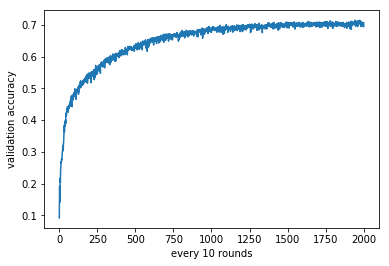

In [32]:
plt.plot(accuracy2)
plt.ylabel('validation accuracy')
plt.xlabel('every 10 rounds')
plt.show()

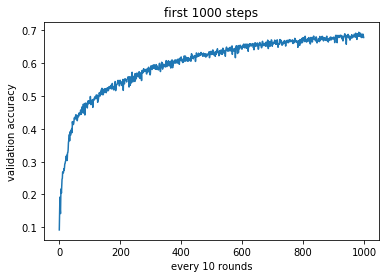

In [35]:
plt.plot(accuracy2[0:1000])
plt.title('first 1000 steps')
plt.ylabel('validation accuracy')
plt.xlabel('every 10 rounds')
plt.show()

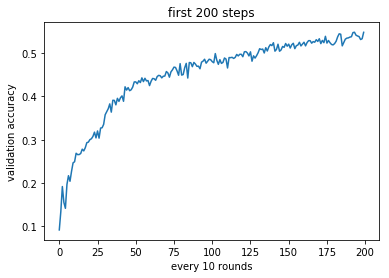

In [43]:
plt.plot(accuracy2[0:200])
plt.title('first 200 steps')
plt.ylabel('validation accuracy')
plt.xlabel('every 10 rounds')
plt.show()

### vgg4_small_filters

In [19]:
accuracy1,time1=test_model('adam','vgg4_small_filters',64,2000)

Tensor("model/logits_vgg4_small_filters:0", shape=(?, 10), dtype=float32) Tensor("y:0", shape=(?, 10), dtype=float32)
Step   0: training accuracy 0.0920
    sample pred: [4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4]
    sample true: [6 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9 6]
    correct predictions by class: [  0.   0.   0.   0.  92.   0.   0.   0.   0.   0.]
Step   0: val accuracy 0.1038
Step  10: training accuracy 0.1100
    sample pred: [5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 5 5 5 5 5]
    sample true: [6 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9 6]
    correct predictions by class: [  0.   0.   0.   0.   0.  93.   0.   0.   0.  17.]
Step  10: val accuracy 0.1058
Step  20: training accuracy 0.1660
    sample pred: [5 0 0 0 5 5 5 5 5 5 0 5 0 0 0 0 5 5 5 5]
    sample true: [6 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9 6]
    correct predictions by class: [ 91.   0.   0.   0.   0.  75.   0.   0.   0.   0.]
Step  20: val accuracy 0.1442
Step  30: training accuracy 0.1250
    sample pred: [1 0 0 0 0 1 0 1 1 1 0 

    sample pred: [6 9 9 8 5 6 4 6 3 9 0 9 4 9 9 0 3 6 7 3]
    sample true: [6 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9 6]
    correct predictions by class: [ 63.  17.   3.  24.  12.  40.  60.  31.  24.  61.]
Step 300: val accuracy 0.3268
Step 310: training accuracy 0.3330
    sample pred: [7 9 9 8 5 6 4 6 6 9 0 9 4 9 9 0 5 6 7 4]
    sample true: [6 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9 6]
    correct predictions by class: [ 58.  11.  11.   1.  24.  46.  50.  40.  26.  66.]
Step 310: val accuracy 0.3366
Step 320: training accuracy 0.3550
    sample pred: [1 9 1 8 5 6 4 6 1 9 0 9 2 1 9 0 1 6 7 4]
    sample true: [6 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9 6]
    correct predictions by class: [ 53.  48.  16.   2.  15.  38.  49.  45.  25.  64.]
Step 320: val accuracy 0.3520
Step 330: training accuracy 0.3550
    sample pred: [7 9 9 8 5 6 4 6 1 9 0 9 2 9 9 0 6 6 7 6]
    sample true: [6 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9 6]
    correct predictions by class: [ 45.  23.  18.   3.   7.  26.  68.  64. 

Step 600: val accuracy 0.4300
Step 610: training accuracy 0.4150
    sample pred: [7 9 9 8 5 6 4 4 6 9 0 9 4 9 9 0 1 6 9 4]
    sample true: [6 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9 6]
    correct predictions by class: [ 50.  45.  14.  11.  34.  40.  49.  67.  32.  73.]
Step 610: val accuracy 0.4306
Step 620: training accuracy 0.4020
    sample pred: [7 9 1 8 3 6 4 4 6 9 0 9 4 1 1 0 3 6 1 4]
    sample true: [6 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9 6]
    correct predictions by class: [ 66.  47.  10.  24.  52.  26.  46.  42.  41.  48.]
Step 620: val accuracy 0.4258
Step 630: training accuracy 0.4190
    sample pred: [7 9 1 8 3 6 4 6 6 9 0 9 4 1 1 0 3 6 1 6]
    sample true: [6 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9 6]
    correct predictions by class: [ 42.  51.   9.  22.  32.  30.  62.  58.  52.  61.]
Step 630: val accuracy 0.4266
Step 640: training accuracy 0.4170
    sample pred: [7 9 9 8 3 6 4 4 3 9 0 9 2 9 9 0 3 6 9 4]
    sample true: [6 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9 6]
    correc

Step 910: val accuracy 0.4556
Step 920: training accuracy 0.4480
    sample pred: [7 9 1 8 3 4 4 4 3 9 0 9 4 1 1 0 1 6 9 4]
    sample true: [6 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9 6]
    correct predictions by class: [ 41.  59.  19.  29.  48.  31.  43.  57.  54.  67.]
Step 920: val accuracy 0.4604
Step 930: training accuracy 0.4350
    sample pred: [7 9 1 8 3 6 4 6 3 9 0 9 2 1 9 0 3 6 9 3]
    sample true: [6 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9 6]
    correct predictions by class: [ 44.  47.  20.  52.  31.  13.  45.  58.  53.  72.]
Step 930: val accuracy 0.4472
Step 940: training accuracy 0.4420
    sample pred: [7 9 1 8 5 6 4 6 3 9 0 9 2 1 1 0 1 6 9 6]
    sample true: [6 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9 6]
    correct predictions by class: [ 48.  56.  27.  16.  27.  45.  53.  54.  48.  68.]
Step 940: val accuracy 0.4686
Step 950: training accuracy 0.4580
    sample pred: [7 9 1 8 3 6 4 6 6 9 0 9 2 1 1 0 1 6 9 4]
    sample true: [6 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9 6]
    correc

Step 1220: val accuracy 0.4830
Step 1230: training accuracy 0.4640
    sample pred: [5 9 1 8 3 2 4 6 3 9 0 9 2 1 1 0 1 6 9 6]
    sample true: [6 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9 6]
    correct predictions by class: [ 47.  48.  53.  31.  16.  36.  47.  59.  63.  64.]
Step 1230: val accuracy 0.4874
Step 1240: training accuracy 0.4700
    sample pred: [3 9 1 1 3 6 4 3 3 9 0 9 2 1 1 0 3 6 9 6]
    sample true: [6 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9 6]
    correct predictions by class: [ 49.  55.  37.  50.  25.  20.  49.  66.  53.  66.]
Step 1240: val accuracy 0.4814
Step 1250: training accuracy 0.4820
    sample pred: [3 9 1 1 3 6 4 6 3 9 0 9 4 1 1 0 3 6 1 6]
    sample true: [6 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9 6]
    correct predictions by class: [ 59.  60.  28.  34.  45.  32.  57.  62.  49.  56.]
Step 1250: val accuracy 0.4832
Step 1260: training accuracy 0.4670
    sample pred: [3 9 9 8 3 6 4 6 3 9 0 9 4 9 9 0 3 6 9 6]
    sample true: [6 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9 6]
  

    sample pred: [7 9 1 1 1 6 4 6 6 9 0 9 6 1 1 0 1 6 9 6]
    sample true: [6 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9 6]
    correct predictions by class: [ 51.  58.  42.  16.  21.  39.  74.  73.  57.  71.]
Step 1530: val accuracy 0.4826
Step 1540: training accuracy 0.4930
    sample pred: [7 9 1 1 1 2 4 6 3 9 0 9 4 1 1 0 1 3 1 6]
    sample true: [6 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9 6]
    correct predictions by class: [ 62.  61.  41.  39.  34.  39.  47.  54.  60.  56.]
Step 1540: val accuracy 0.5018
Step 1550: training accuracy 0.5000
    sample pred: [7 9 1 1 3 6 4 6 3 9 0 9 4 1 1 0 3 6 9 6]
    sample true: [6 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9 6]
    correct predictions by class: [ 40.  58.  31.  46.  44.  29.  52.  70.  60.  70.]
Step 1550: val accuracy 0.4932
Step 1560: training accuracy 0.5080
    sample pred: [7 9 1 1 3 6 4 6 3 9 0 9 4 1 1 0 3 3 9 6]
    sample true: [6 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9 6]
    correct predictions by class: [ 64.  59.  42.  43.  34.  32.  51.

Step 1830: val accuracy 0.5136
Step 1840: training accuracy 0.4970
    sample pred: [7 9 1 1 1 6 4 6 3 9 0 9 6 1 1 0 1 3 9 6]
    sample true: [6 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9 6]
    correct predictions by class: [ 45.  66.  30.  41.  24.  32.  65.  76.  60.  58.]
Step 1840: val accuracy 0.5028
Step 1850: training accuracy 0.5080
    sample pred: [7 9 1 1 1 2 4 4 3 9 0 9 4 1 1 0 1 3 9 6]
    sample true: [6 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9 6]
    correct predictions by class: [ 59.  64.  46.  44.  40.  33.  48.  60.  60.  54.]
Step 1850: val accuracy 0.5108
Step 1860: training accuracy 0.5010
    sample pred: [7 9 1 1 1 6 4 6 3 9 0 9 4 1 1 0 9 5 9 6]
    sample true: [6 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9 6]
    correct predictions by class: [ 61.  56.  18.  19.  37.  54.  56.  69.  61.  70.]
Step 1860: val accuracy 0.5078
Step 1870: training accuracy 0.5090
    sample pred: [7 9 1 8 3 6 4 6 3 9 0 9 4 1 1 0 9 3 9 6]
    sample true: [6 7 9 0 5 2 3 3 3 9 0 9 2 9 1 0 2 3 9 6]
  

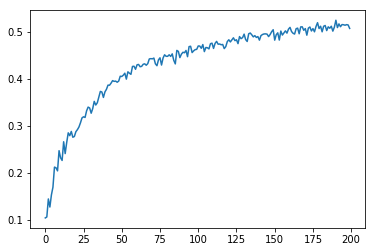

In [21]:
plt.plot(accuracy1)
plt.show()

In [22]:
time1

22.211057925224303